In [2]:
from sklearn import metrics
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import torch

import matplotlib.pyplot as plt
import shap

from cuml.ensemble import RandomForestRegressor as cuRF
from cuml.neighbors import KNeighborsRegressor as cuKNeighborsRegressor
from cuml.svm import SVR as cuSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LassoCV 
from sklearn.feature_selection import SelectFromModel, mutual_info_regression
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA

import os
os.chdir("/local-scratch/GlucoseProject/mobicom23_mobispectral/regression")
import sys
sys.path.append(os.getcwd())
from utils import *
from config import *

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [3]:
BANDS_WAVELENGTHS = [397.32, 400.20, 403.09, 405.97, 408.85, 411.74, 414.63, 417.52, 420.40, 423.29, 426.19, 429.08, 431.97, 434.87, 437.76, 440.66, 443.56, 446.45, 449.35, 452.25, 455.16, 458.06, 460.96, 463.87, 466.77, 469.68, 472.59, 475.50, 478.41, 481.32, 484.23, 487.14, 490.06, 492.97, 495.89, 498.80, 501.72, 504.64, 507.56, 510.48, 513.40, 516.33, 519.25, 522.18, 525.10, 528.03, 530.96, 533.89, 536.82, 539.75, 542.68, 545.62, 548.55, 551.49, 554.43, 557.36, 560.30, 563.24, 566.18, 569.12, 572.07, 575.01, 577.96, 580.90, 583.85, 586.80, 589.75, 592.70, 595.65, 598.60, 601.55, 604.51, 607.46, 610.42, 613.38, 616.34, 619.30, 622.26, 625.22, 628.18, 631.15, 634.11, 637.08, 640.04, 643.01, 645.98, 648.95, 651.92, 654.89, 657.87, 660.84, 663.81, 666.79, 669.77, 672.75, 675.73, 678.71, 681.69, 684.67, 687.65, 690.64, 693.62, 696.61, 699.60, 702.58, 705.57, 708.57, 711.56, 714.55, 717.54, 720.54, 723.53, 726.53, 729.53, 732.53, 735.53, 738.53, 741.53, 744.53, 747.54, 750.54, 753.55, 756.56, 759.56, 762.57, 765.58, 768.60, 771.61, 774.62, 777.64, 780.65, 783.67, 786.68, 789.70, 792.72, 795.74, 798.77, 801.79, 804.81, 807.84, 810.86, 813.89, 816.92, 819.95, 822.98, 826.01, 829.04, 832.07, 835.11, 838.14, 841.18, 844.22, 847.25, 850.29, 853.33, 856.37, 859.42, 862.46, 865.50, 868.55, 871.60, 874.64, 877.69, 880.74, 883.79, 886.84, 889.90, 892.95, 896.01, 899.06, 902.12, 905.18, 908.24, 911.30, 914.36, 917.42, 920.48, 923.55, 926.61, 929.68, 932.74, 935.81, 938.88, 941.95, 945.02, 948.10, 951.17, 954.24, 957.32, 960.40, 963.47, 966.55, 969.63, 972.71, 975.79, 978.88, 981.96, 985.05, 988.13, 991.22, 994.31, 997.40, 1000.49, 1003.58]

In [18]:
print(BANDS_WAVELENGTHS[182:186])

[938.88, 941.95, 945.02, 948.1]


### Delete bands 182:186

In [2]:
BANDS_WAVELENGTHS = [397.32, 400.20, 403.09, 405.97, 408.85, 411.74, 414.63, 417.52, 420.40, 423.29, 426.19, 429.08, 431.97, 434.87, 437.76, 440.66, 443.56, 446.45, 449.35, 452.25, 455.16, 458.06, 460.96, 463.87, 466.77, 469.68, 472.59, 475.50, 478.41, 481.32, 484.23, 487.14, 490.06, 492.97, 495.89, 498.80, 501.72, 504.64, 507.56, 510.48, 513.40, 516.33, 519.25, 522.18, 525.10, 528.03, 530.96, 533.89, 536.82, 539.75, 542.68, 545.62, 548.55, 551.49, 554.43, 557.36, 560.30, 563.24, 566.18, 569.12, 572.07, 575.01, 577.96, 580.90, 583.85, 586.80, 589.75, 592.70, 595.65, 598.60, 601.55, 604.51, 607.46, 610.42, 613.38, 616.34, 619.30, 622.26, 625.22, 628.18, 631.15, 634.11, 637.08, 640.04, 643.01, 645.98, 648.95, 651.92, 654.89, 657.87, 660.84, 663.81, 666.79, 669.77, 672.75, 675.73, 678.71, 681.69, 684.67, 687.65, 690.64, 693.62, 696.61, 699.60, 702.58, 705.57, 708.57, 711.56, 714.55, 717.54, 720.54, 723.53, 726.53, 729.53, 732.53, 735.53, 738.53, 741.53, 744.53, 747.54, 750.54, 753.55, 756.56, 759.56, 762.57, 765.58, 768.60, 771.61, 774.62, 777.64, 780.65, 783.67, 786.68, 789.70, 792.72, 795.74, 798.77, 801.79, 804.81, 807.84, 810.86, 813.89, 816.92, 819.95, 822.98, 826.01, 829.04, 832.07, 835.11, 838.14, 841.18, 844.22, 847.25, 850.29, 853.33, 856.37, 859.42, 862.46, 865.50, 868.55, 871.60, 874.64, 877.69, 880.74, 883.79, 886.84, 889.90, 892.95, 896.01, 899.06, 902.12, 905.18, 908.24, 911.30, 914.36, 917.42, 920.48, 923.55, 926.61, 929.68, 932.74, 935.81, 951.17, 954.24, 957.32, 960.40, 963.47, 966.55, 969.63, 972.71, 975.79, 978.88, 981.96, 985.05, 988.13, 991.22, 994.31, 997.40, 1000.49, 1003.58]

In [5]:
print(BANDS_WAVELENGTHS[182])
print(BANDS_WAVELENGTHS[185])

938.88
948.1


In [3]:
num_features_to_select = 50

In [3]:
subject_id_test = [2]
# Everything else from the subject_id_test
subject_id_train = [1, 3]

In [4]:
filter_rows_by_id("../" + HYPER_LABELS_FILE, "../" + TEST_FILE, subject_id_test)
filter_rows_by_id("../" + HYPER_LABELS_FILE, "../" + TRAIN_FILE, subject_id_train)

## Data understanding

In [3]:
X, y, image_list_train, image_list_test = get_all_data('../datasets/dataset_glucose/Hyperspectral', 'train_data.csv', 'test_data.csv', 1, 'hyper')

Loading hyper dataset
Loading hyper dataset


In [6]:
print(X.shape)

(847925, 200)


In [ ]:
X, y, image_list_train, image_list_test = get_all_data('../datasets/dataset_glucose/Hyperspectral', 'train_data_temp.csv', 'test_data_temp.csv', 1, 'hyper')

In [2]:
data_root = '../datasets/dataset_glucose/mobile/GooglePixel4XL'
file_train = 'mobi_train.csv'
file_test = 'mobi_test.csv'
step = 1

Loading Mobile dataset
Loading Mobile dataset


In [3]:
data_root = '../datasets/dataset_glucose/mobile/RaspberryPi-RGB+ToF'
file_train = 'mobi_train.csv'
file_test = 'mobi_test.csv'
step = 1

Loading Mobile dataset
Loading Mobile dataset


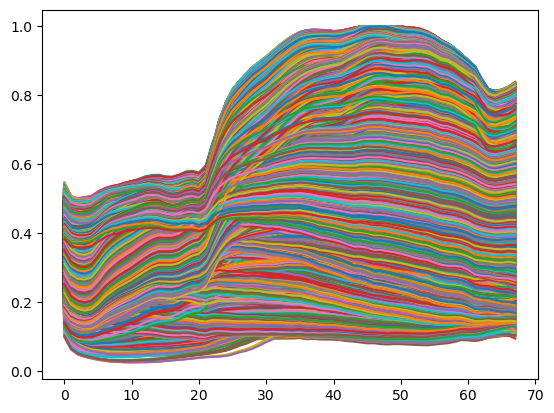

In [4]:
X, y, image_list_train, image_list_test = get_all_data(data_root, file_train, file_test, step, 'mobi')

In [7]:
low_signal = image_list_train.get_low_signal(65, 0.15)

In [8]:
print("Low signal images: ", low_signal)

Low signal images:  {1, 2, 3, 24, 25, 26, 27, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 76, 77, 78, 79, 80, 81, 82, 83, 85, 87}


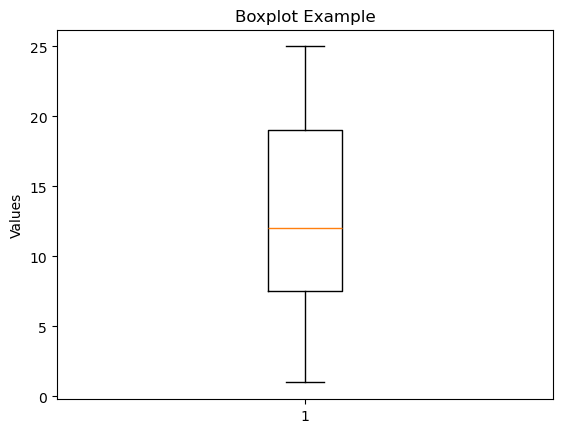

In [7]:
import matplotlib.pyplot as plt

# Example data
data = [1, 2, 5, 7, 8, 8, 10, 12, 14, 15, 18, 20, 21, 22, 25]

# Creating a boxplot
plt.boxplot(data)
plt.title('Boxplot Example')
plt.ylabel('Values')
plt.show()


Mean: [0.19047609 0.12684527 0.08427567 0.05586017 0.03672166 0.02505406
 0.01726172 0.01244076 0.00917369 0.00683545 0.0056808  0.00754231
 0.01209264 0.02028341 0.03274124 0.04940226 0.07005782 0.09237902
 0.11361744 0.13291082 0.14916994 0.16374303 0.17612372 0.18780668
 0.1976852  0.20748174 0.21545339 0.22297913 0.22919174 0.23555139
 0.24175456 0.2489039  0.25653532 0.2642031  0.27165908 0.2781561
 0.28478622 0.29009467 0.29574168 0.30021054 0.30329603 0.30453476
 0.3041646  0.30240914 0.2984595  0.2935633  0.2882912  0.28336146
 0.278915   0.2757045  0.2736953  0.2741443  0.27687    0.2807705
 0.28599095 0.29056308 0.29564422 0.29980522 0.3041934  0.30617818
 0.30654514 0.3064986  0.31249195 0.32633424 0.35046795 0.38247797
 0.41982752 0.4587569  0.49671915 0.53397256 0.5685209  0.6004332
 0.62747514 0.65224034 0.67319036 0.6918198  0.7082278  0.72316617
 0.73568994 0.74749017 0.75770986 0.76730555 0.7770155  0.7861674
 0.7952553  0.80273646 0.81046736 0.8176535  0.82531536 0.83

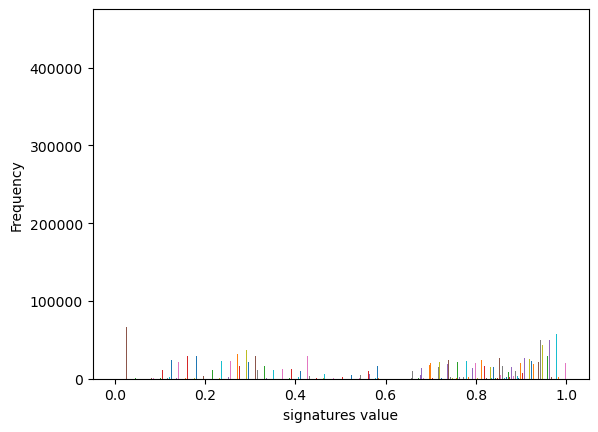

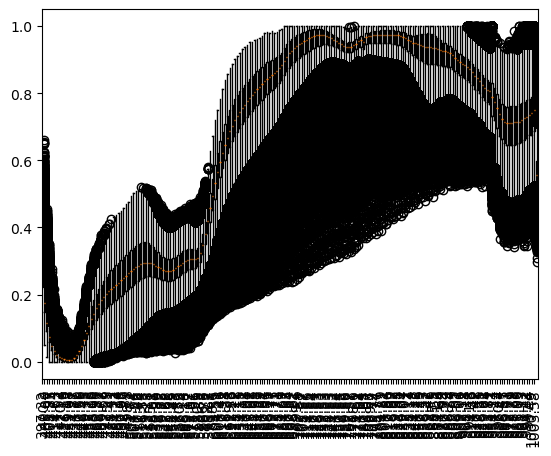

[[ 1.          0.93282312  0.89586369 ... -0.15067734 -0.08719489
   0.35910108]
 [ 0.93282312  1.          0.92889955 ... -0.26376567 -0.20303544
   0.24581484]
 [ 0.89586369  0.92889955  1.         ... -0.3449165  -0.29255656
   0.15240805]
 ...
 [-0.15067734 -0.26376567 -0.3449165  ...  1.          0.9138852
   0.73798256]
 [-0.08719489 -0.20303544 -0.29255656 ...  0.9138852   1.
   0.77207396]
 [ 0.35910108  0.24581484  0.15240805 ...  0.73798256  0.77207396
   1.        ]]


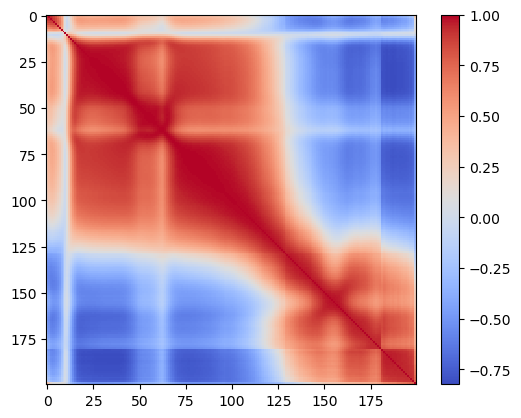

In [7]:
# Summary statistics
print("Mean:", np.mean(X, axis=0))
print("Mean size: ", np.mean(X, axis=0).shape)
print("Median:", np.median(X, axis=0))
print("Standard Deviation:", np.std(X, axis=0))

# Visualizations
plt.hist(X, bins=200)
plt.ylabel('Frequency')
plt.xlabel('signatures value')
plt.show()

plt.boxplot(X)
plt.xticks(range(200), BANDS_WAVELENGTHS[::1], rotation=90)
plt.show()

# Correlation
correlation_matrix = np.corrcoef(X, rowvar=False)
print(correlation_matrix)
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.show()

In [ ]:
# Summary statistics
print("Mean:", np.mean(X, axis=0))
print("Mean size: ", np.mean(X, axis=0).shape)
print("Median:", np.median(X, axis=0))
print("Standard Deviation:", np.std(X, axis=0))

# Visualizations
plt.hist(X, bins=200)
plt.ylabel('Frequency')
plt.xlabel('signatures value')
plt.show()

plt.boxplot(X)
plt.xticks(range(0, 204, 10), BANDS_WAVELENGTHS[0::10], rotation=90)
plt.show()

# Correlation
correlation_matrix = np.corrcoef(X, rowvar=False)
print(correlation_matrix)
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.show()

In [10]:
data_root = '../datasets/dataset_glucose/Hyperspectral'
file_train = 'train_data.csv'
file_test = 'test_data.csv'
step = 1

In [5]:
data_root = '../datasets/dataset_glucose/Hyperspectral'
file_train = 'train_data_temp.csv'
file_test = 'test_data_temp.csv'
step = 1

In [9]:
data_root = '../datasets/dataset_glucose/mobile/GooglePixel4XL'
file_train = 'mobi_train.csv'
file_test = 'mobi_test.csv'
step = 1

In [18]:
make_train_test_files('../datasets/dataset_glucose/mobile/GooglePixel4XL/labels_GooglePixel.csv', '../datasets/dataset_glucose/mobile/GooglePixel4XL/mobi_train.csv', '../datasets/dataset_glucose/mobile/GooglePixel4XL/mobi_test.csv', 0.2)

## Feature understanding

In [19]:
X_train, y_train, X_test, y_test, test_data = prepare_data(data_root, file_train, file_test, step, 'mobi')
# X_train, X_val, y_train, y_val = TTS(X_train, y_train, test_size=0.3, random_state=42)

Loading Mobile dataset
Loading Mobile dataset


In [11]:
X_train, y_train, X_test, y_test, test_data = prepare_data(data_root, file_train, file_test, step, 'hyper')
# X_train, X_val, y_train, y_val = TTS(X_train, y_train, test_size=0.3, random_state=42)

Loading hyper dataset


Loading hyper dataset


In [6]:
# Scale data
# scaler = StandardScaler()
x_scaler = StandardScaler()
y_scaler = StandardScaler()
X_train = x_scaler.fit_transform(X_train)
# X_val = scaler.transform(X_val)
X_test = x_scaler.transform(X_test)
# y_train = y_scaler.fit_transform(y_train.reshape(-1, 1))
# y_test = y_scaler.transform(y_test.reshape(-1, 1))

In [4]:
# Scale data
# scaler = StandardScaler()
x_scaler = RobustScaler()
X = x_scaler.fit_transform(X)
# X_val = scaler.transform(X_val)
# X_test = scaler.transform(X_test)

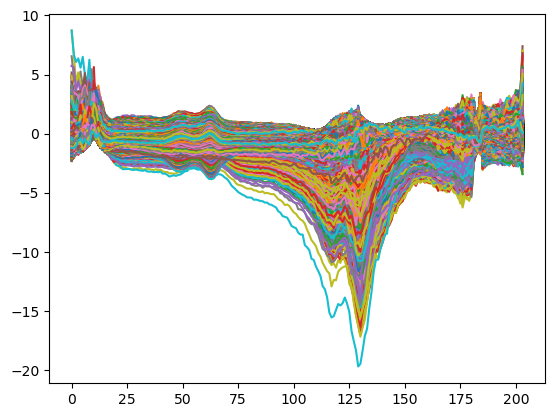

In [7]:
for row in X:
    plt.plot(row)

In [5]:
import cupy as cp
X_train = cp.array(X_train)
# X_val = cp.array(X_val)
X_test = cp.array(X_test)

In [5]:
model = XGBRegressor(n_estimators=250
           ,subsample=0.5236842105263158
           ,random_state=42
           ,tree_method='hist'
           ,device='cuda'
           ,n_job=-1
           ,learning_rate=0.1)

In [7]:
X_train = cp.asnumpy(X_train)
# X_val = cp.asnumpy(X_val)
X_test = cp.asnumpy(X_test)

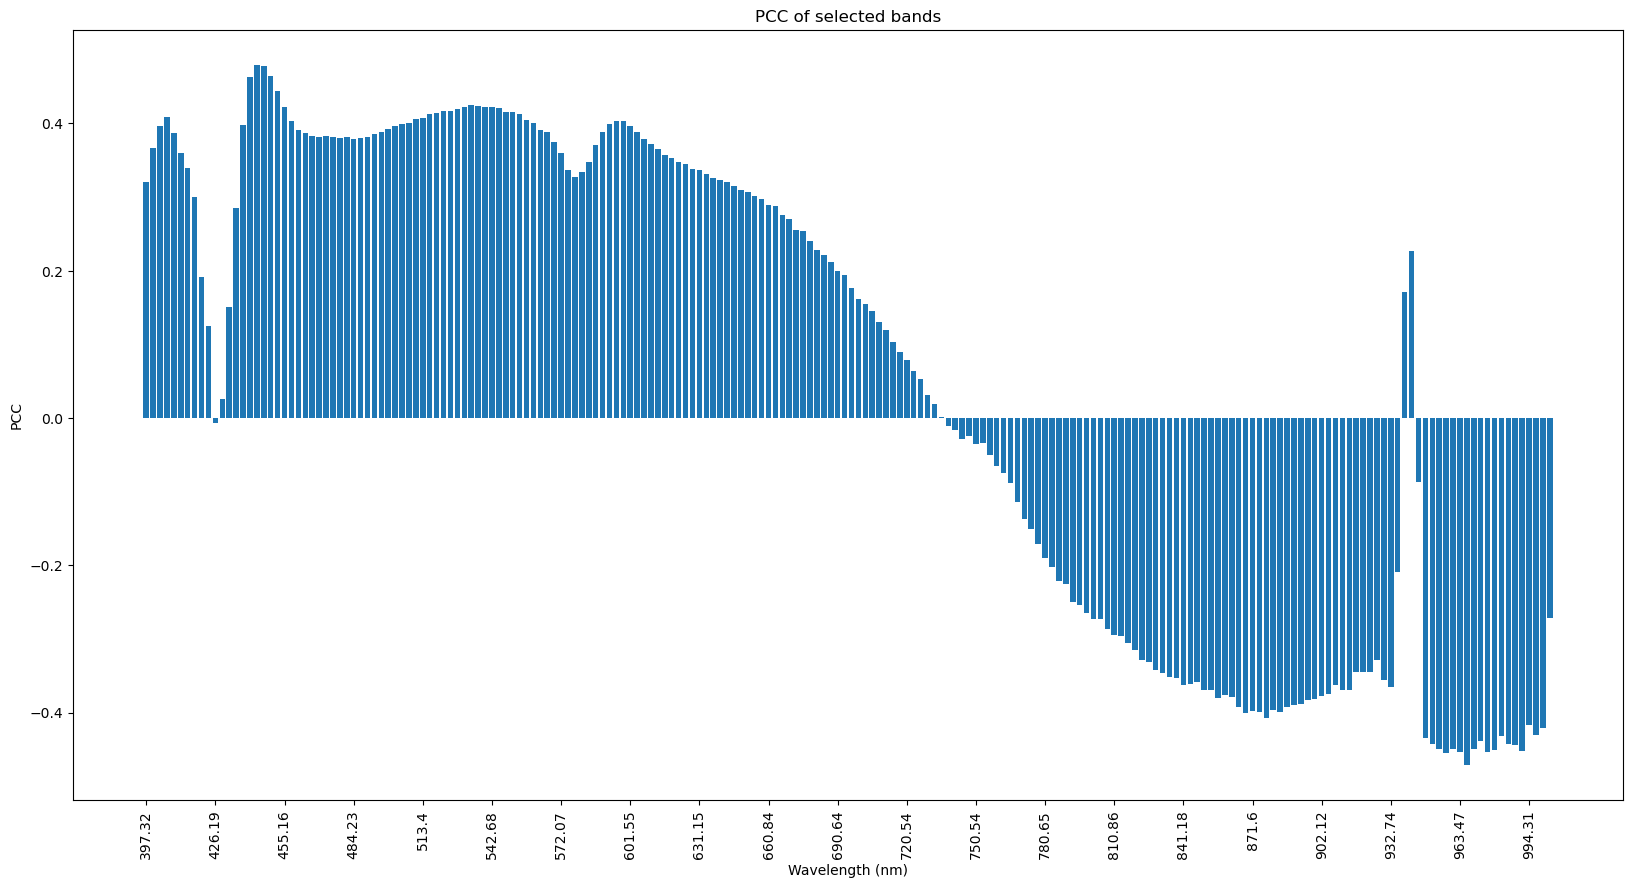

In [19]:
# PCC plot
correlations = []
for i in range(X.shape[1]):
    corr, _ = pearsonr(X[:, i], y)
    correlations.append(corr)

plt.figure(figsize=(20, 10))
plt.bar(range(len(BANDS_WAVELENGTHS)), correlations)
plt.xlabel('Wavelength (nm)')
plt.ylabel('PCC')
plt.title('PCC of selected bands')
# xticks is band wavelengths, but 10 apart from each tick
plt.xticks(range(0, 204, 10), BANDS_WAVELENGTHS[0::10], rotation=90)
plt.show()

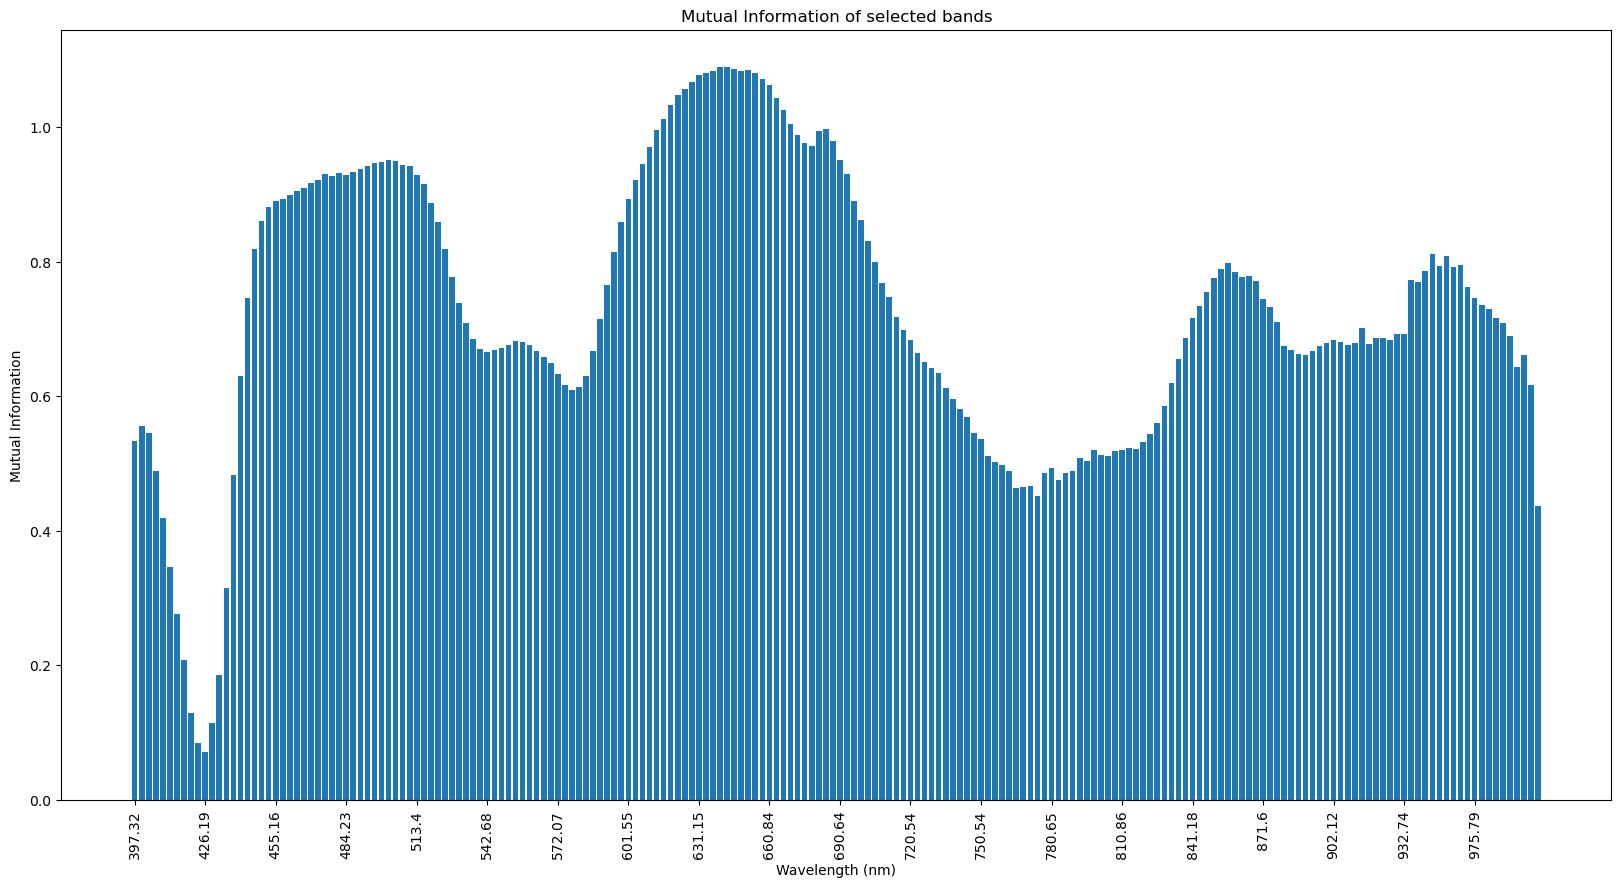

In [11]:
# Calculate mutual information
# 12 Subjects 201 hyper images
mi = mutual_info_regression(X, y, random_state=42)

# Plot mutual information
plt.figure(figsize=(20, 10))
plt.bar(range(len(BANDS_WAVELENGTHS)), mi)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Mutual Information')
plt.title('Mutual Information of selected bands')
# xticks is band wavelengths, but 10 apart from each tick
plt.xticks(range(0, 200, 10), BANDS_WAVELENGTHS[0::10], rotation=90)
plt.show()

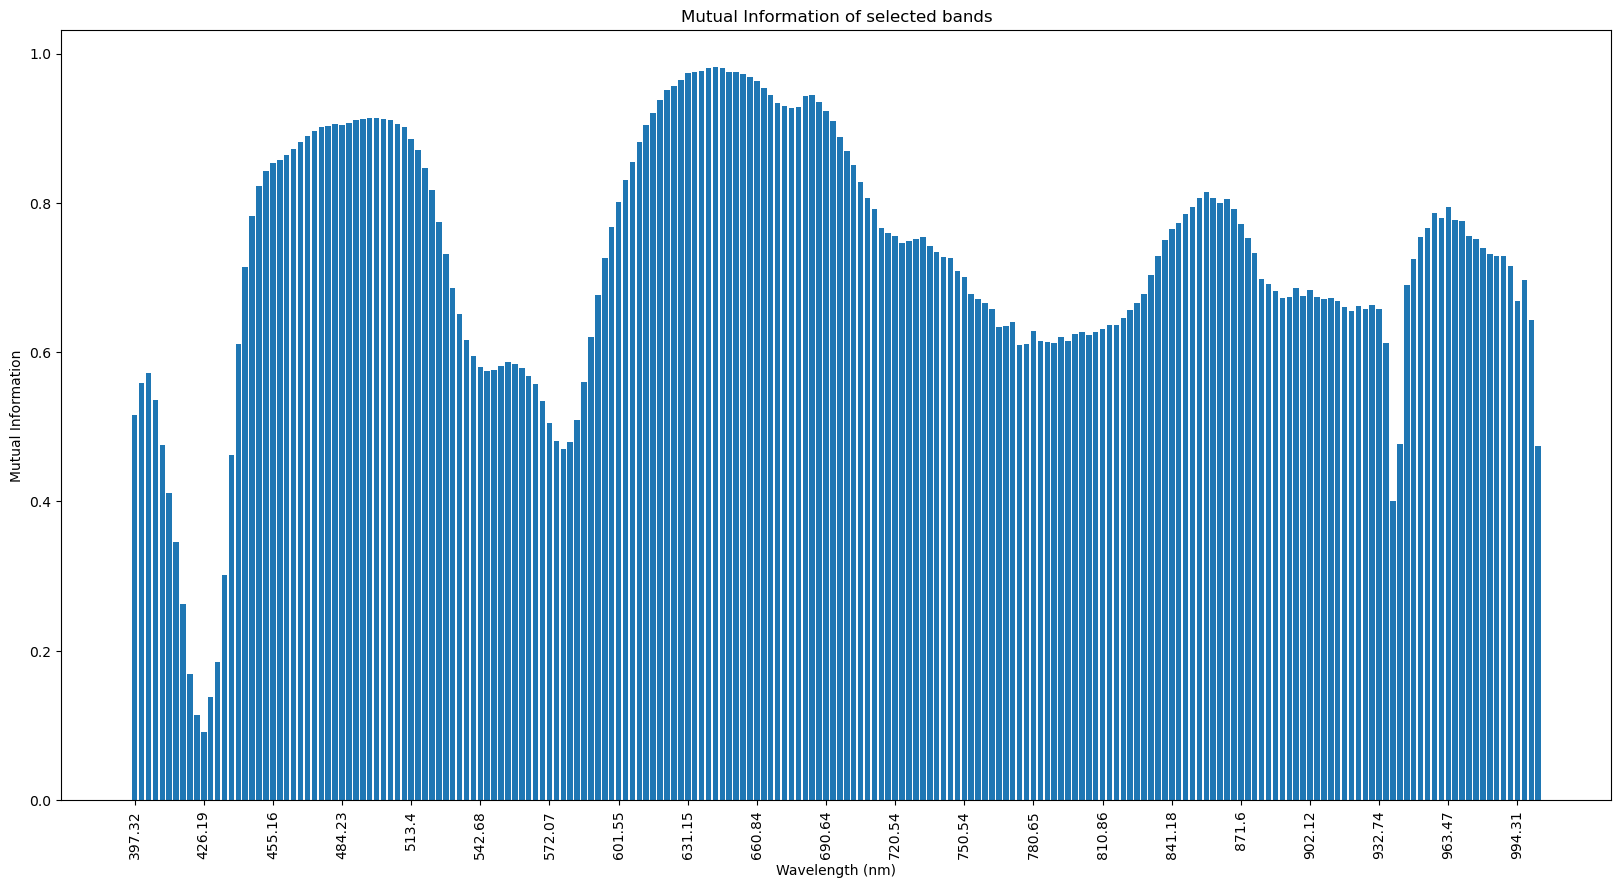

In [6]:
# Calculate mutual information
# 11 subjects 157 hyper images
mi = mutual_info_regression(X, y)

# Plot mutual information
plt.figure(figsize=(20, 10))
plt.bar(range(len(BANDS_WAVELENGTHS)), mi)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Mutual Information')
plt.title('Mutual Information of selected bands')
# xticks is band wavelengths, but 10 apart from each tick
plt.xticks(range(0, 204, 10), BANDS_WAVELENGTHS[0::10], rotation=90)
plt.show()

Selected bands:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 51 52 53 54
 55 56]


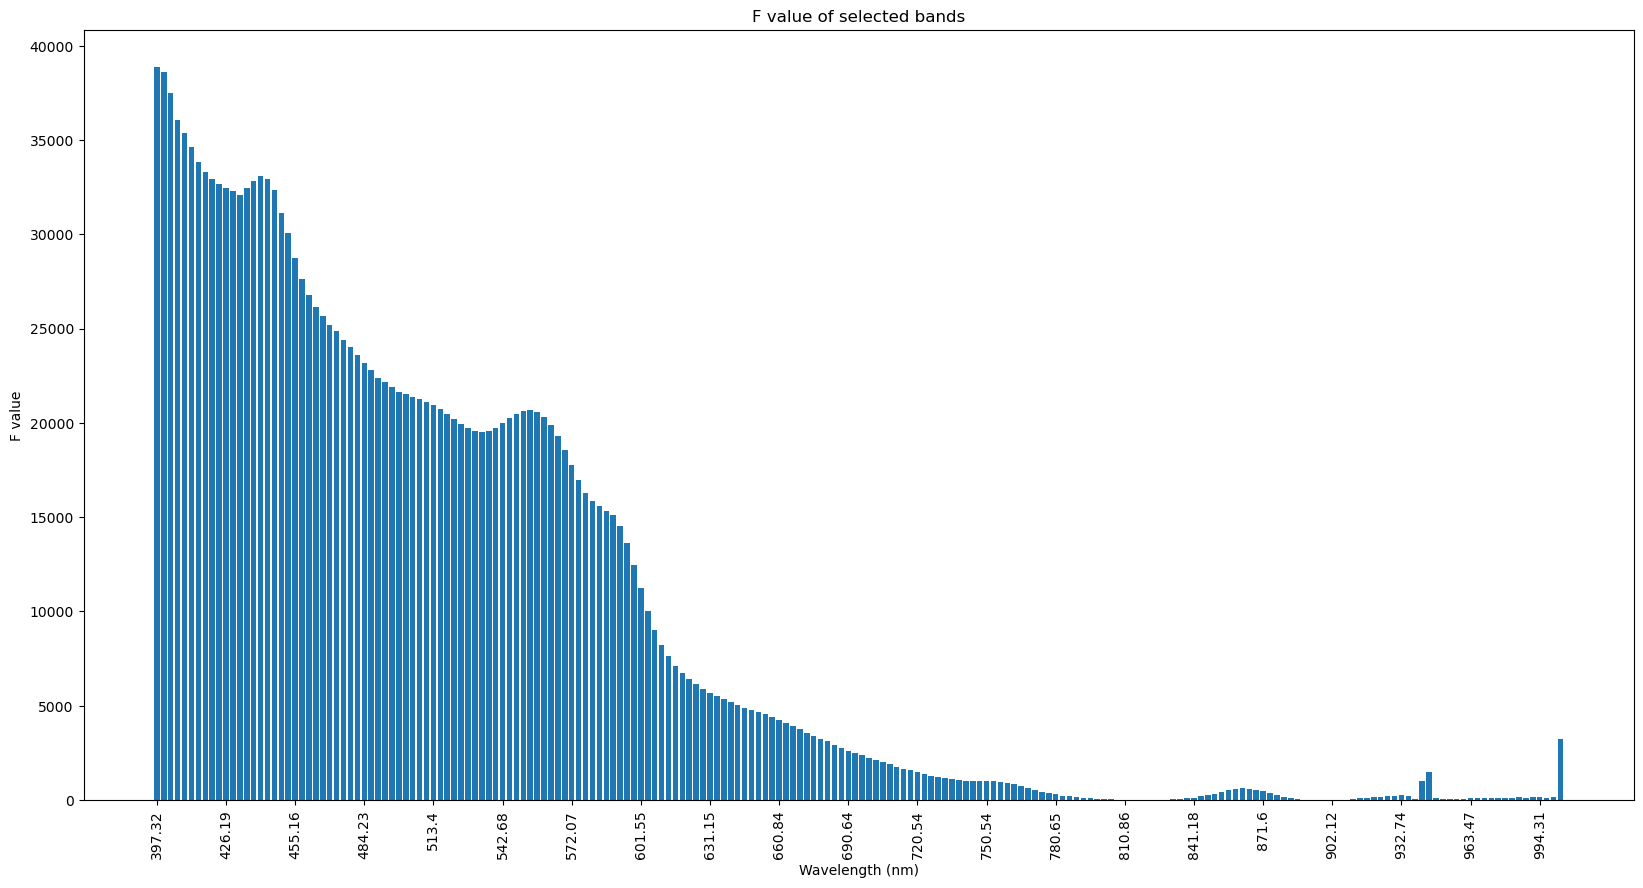

In [9]:
# Robust Scaler, without x_val, Step 1
from sklearn.feature_selection import SelectKBest, f_regression
selector = SelectKBest(score_func=f_regression, k=num_features_to_select)
X_new = selector.fit_transform(X_train, y_train)

selected_feature_indices = selector.get_support(indices=True)

print('Selected bands: ', selected_feature_indices)

plt.figure(figsize=(20, 10))
plt.bar(range(len(BANDS_WAVELENGTHS)), selector.scores_)
plt.xlabel('Wavelength (nm)')
plt.ylabel('F value')
plt.title('F value of selected bands')
# xticks is band wavelengths, but 25 apart from each tick
plt.xticks(range(0, 204, 10), BANDS_WAVELENGTHS[0::10], rotation=90)
plt.show()

In [ ]:
# Robust Scaler, without x_val
from sklearn.feature_selection import SelectKBest, f_regression
selector = SelectKBest(score_func=f_regression, k=num_features_to_select)
X_new = selector.fit_transform(X_train, y_train)

selected_feature_indices = selector.get_support(indices=True)

print('Selected bands: ', selected_feature_indices)

plt.figure(figsize=(20, 10))
plt.bar(range(len(BANDS_WAVELENGTHS)), selector.scores_)
plt.xlabel('Feature')
plt.ylabel('F value')
plt.title('F value of selected bands')
# xticks is band wavelengths, but 25 apart from each tick
plt.xticks(range(0, 204, 25), BANDS_WAVELENGTHS[0::25], rotation=90)
plt.show()

Selected bands:  [  3  15  16  17  18  19  20  21  37  38  39  40  41  42  43  44  45  46
  47  48  49  50  51  52  53  54  55  56  68  69 159 162 185 186 187 188
 189 190 191 192 193 194 195 196 197 198 199 200 201 202]


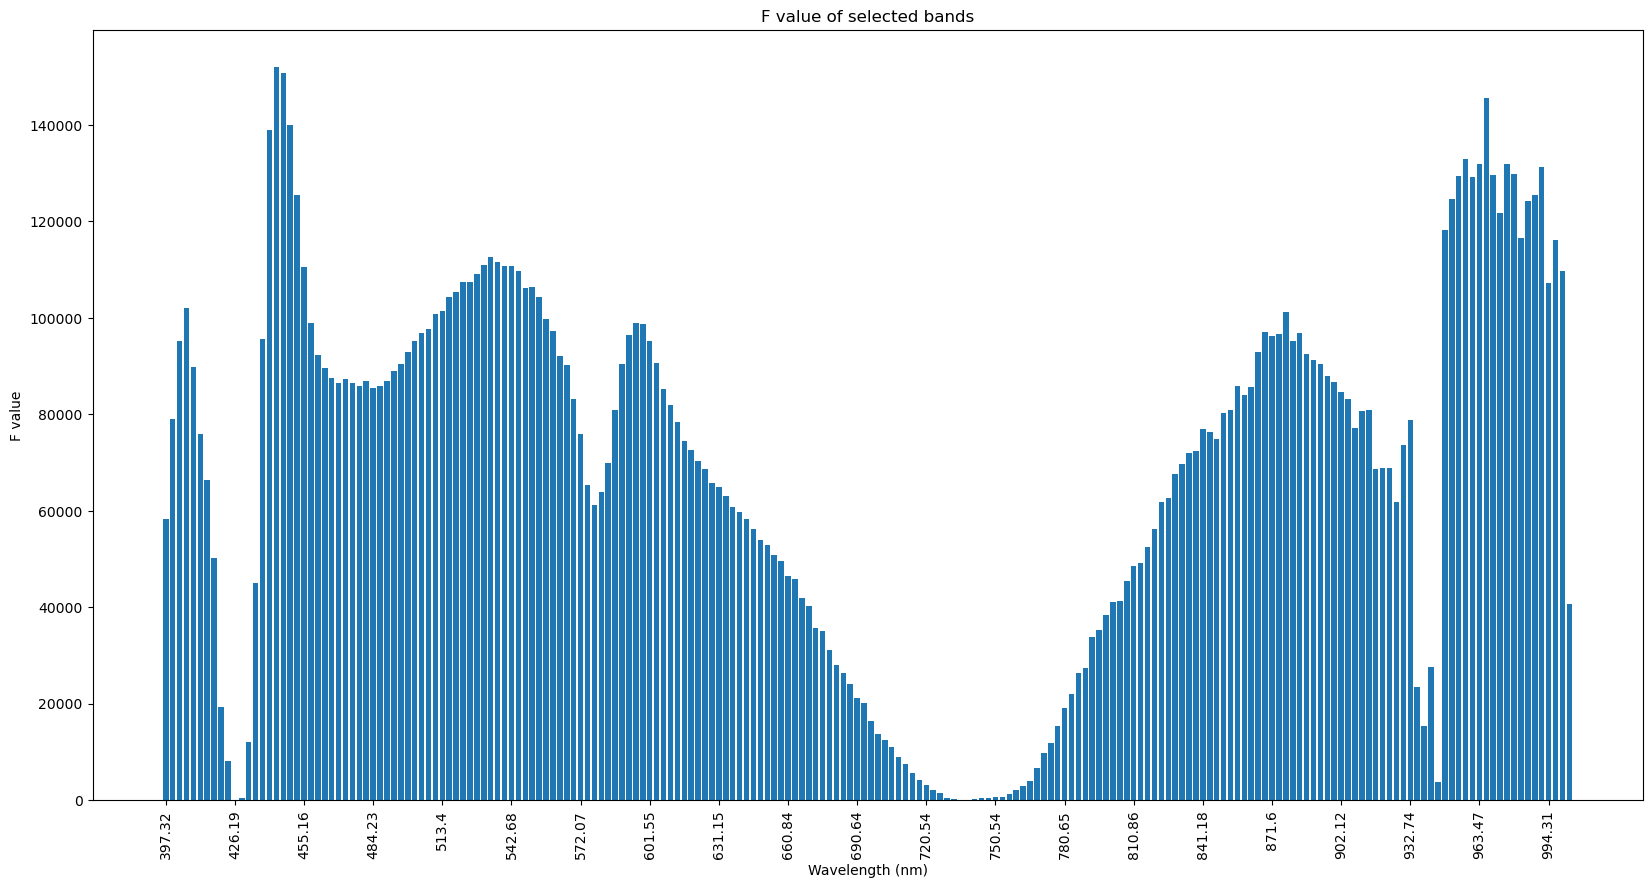

In [22]:
# Robust Scaler, without x_val, Step 1, Full dataset
from sklearn.feature_selection import SelectKBest, f_regression
selector = SelectKBest(score_func=f_regression, k=num_features_to_select)
X_new = selector.fit_transform(X, y)

selected_feature_indices = selector.get_support(indices=True)

print('Selected bands: ', selected_feature_indices)

plt.figure(figsize=(20, 10))
plt.bar(range(len(BANDS_WAVELENGTHS)), selector.scores_)
plt.xlabel('Wavelength (nm)')
plt.ylabel('F value')
plt.title('F value of selected bands')
# xticks is band wavelengths, but 25 apart from each tick
plt.xticks(range(0, 204, 10), BANDS_WAVELENGTHS[0::10], rotation=90)
plt.show()

Selected bands:  [  0   1   2   3   4   5   6   7   8   9  10  48  52  53  54  55  56  57
  58  59  60  61  62  63  65  66  67  68  69  70  78  79  84  85  86  87
  88  89  90  91  92  93  94  95  96  97  98  99 100 101]


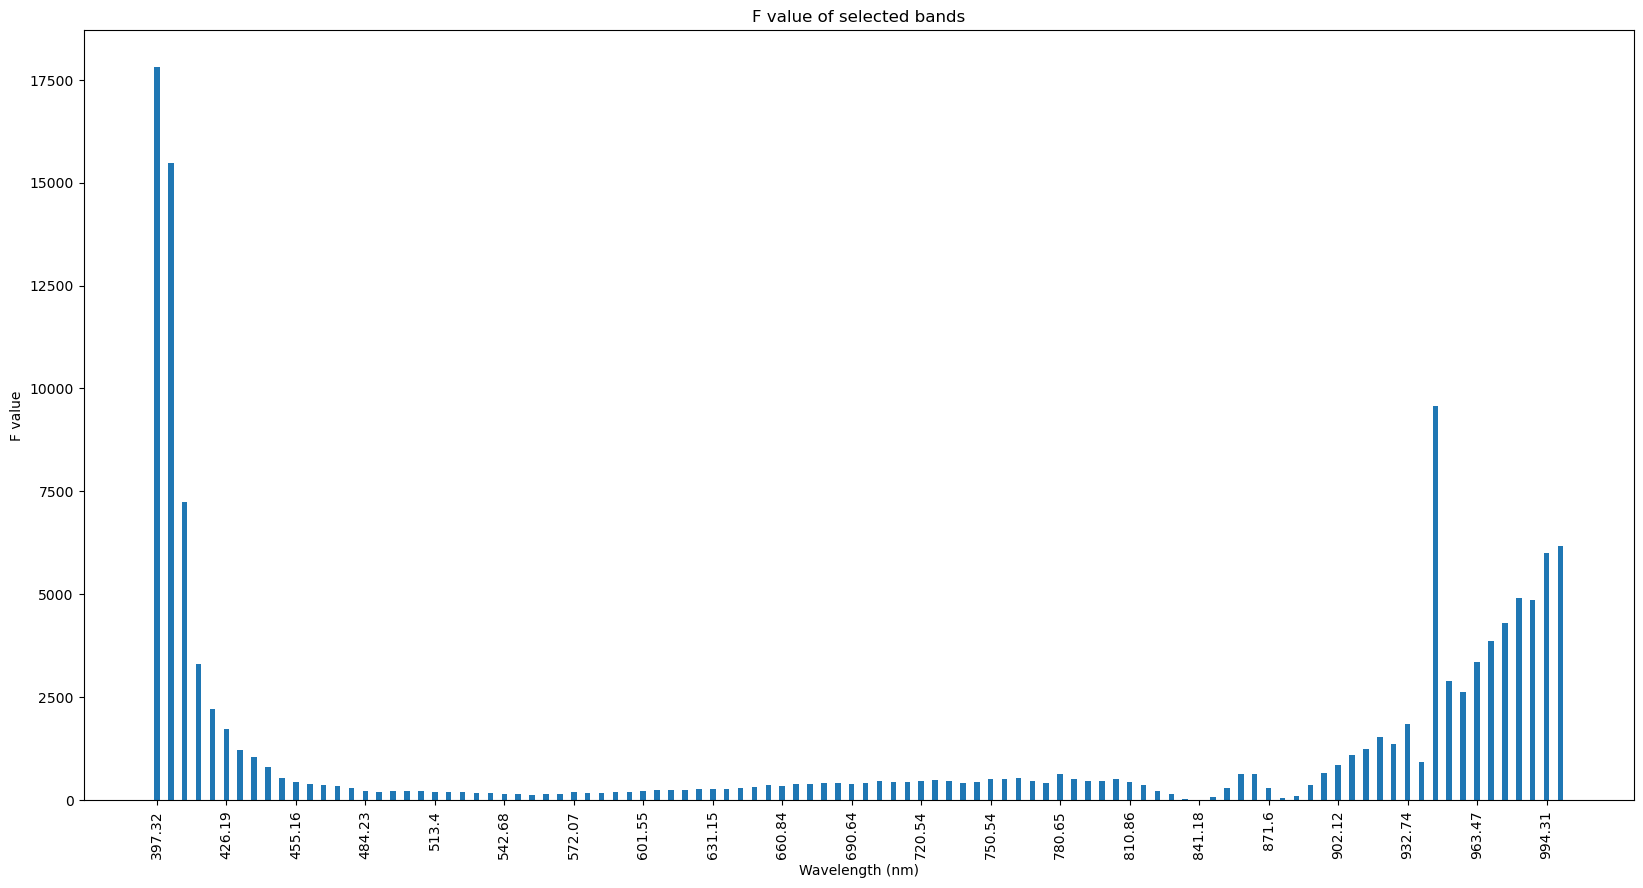

In [26]:
# Robust Scaler, without x_val, Step 2
from sklearn.feature_selection import SelectKBest, f_regression
selector = SelectKBest(score_func=f_regression, k=num_features_to_select)
X_new = selector.fit_transform(X, y)

selected_feature_indices = selector.get_support(indices=True)

print('Selected bands: ', selected_feature_indices)

plt.figure(figsize=(20, 10))
plt.bar(range(0, len(BANDS_WAVELENGTHS), 2), selector.scores_)
plt.xlabel('Wavelength (nm)')
plt.ylabel('F value')
plt.title('F value of selected bands')
# xticks is band wavelengths, but 10 apart from each tick
plt.xticks(range(0, 204, 10), BANDS_WAVELENGTHS[0::10], rotation=90)
plt.show()

Selected bands:  [ 0  1  2  3  4  5  6  7  8  9 10 24 25 26 27 28 29 30 31 32 33 34 35 36
 37 38 39 40 41 42 43 44 45 46 47 48 52 53 56 57 58 59 60 61 62 63 64 65
 66 67]


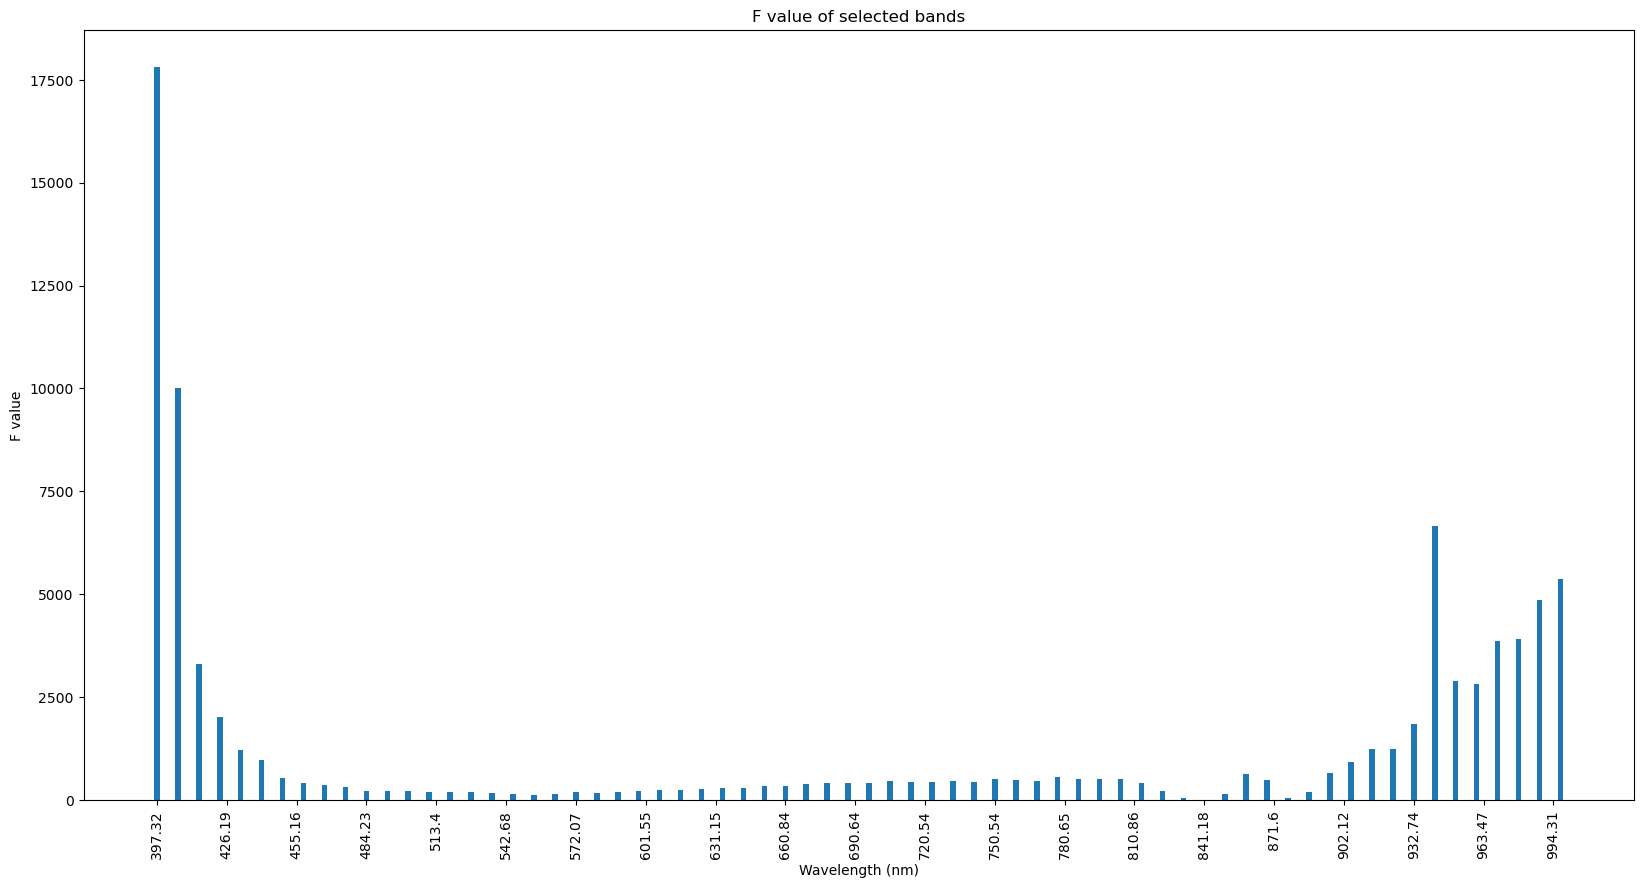

In [28]:
# Robust Scaler, without x_val, Step 3
from sklearn.feature_selection import SelectKBest, f_regression
selector = SelectKBest(score_func=f_regression, k=num_features_to_select)
X_new = selector.fit_transform(X, y)

selected_feature_indices = selector.get_support(indices=True)

print('Selected bands: ', selected_feature_indices)

plt.figure(figsize=(20, 10))
plt.bar(range(0, len(BANDS_WAVELENGTHS), 3), selector.scores_)
plt.xlabel('Wavelength (nm)')
plt.ylabel('F value')
plt.title('F value of selected bands')
# xticks is band wavelengths, but 10 apart from each tick
plt.xticks(range(0, 204, 10), BANDS_WAVELENGTHS[0::10], rotation=90)
plt.show()

Selected bands:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40]


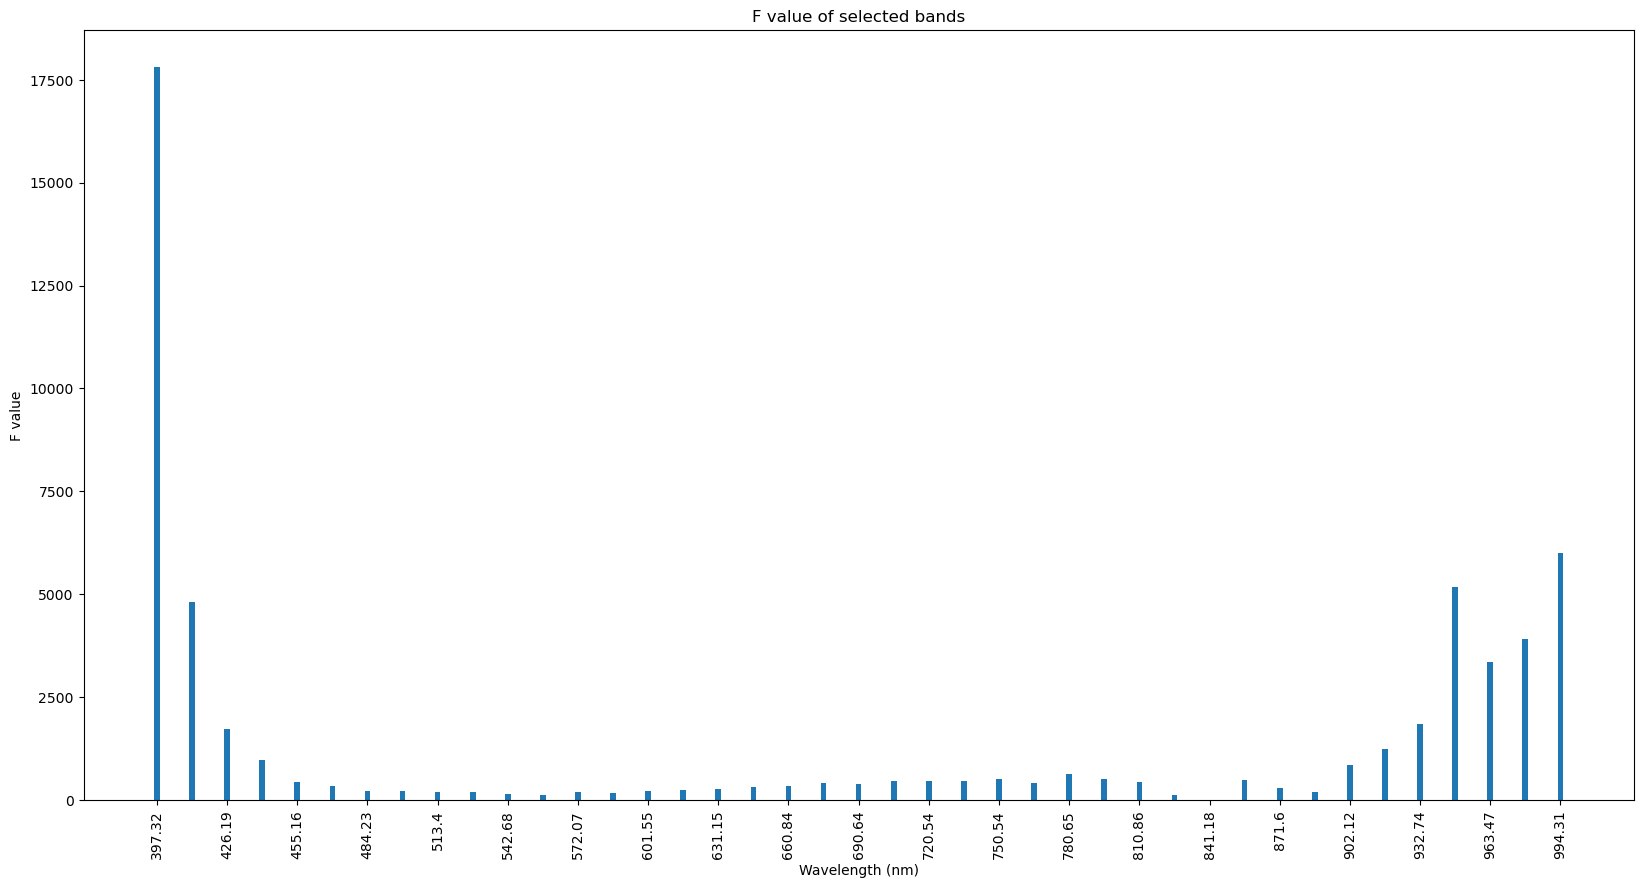

In [30]:
# Robust Scaler, without x_val, Step 5
from sklearn.feature_selection import SelectKBest, f_regression
selector = SelectKBest(score_func=f_regression, k=num_features_to_select)
X_new = selector.fit_transform(X, y)

selected_feature_indices = selector.get_support(indices=True)

print('Selected bands: ', selected_feature_indices)

plt.figure(figsize=(20, 10))
plt.bar(range(0, len(BANDS_WAVELENGTHS), 5), selector.scores_)
plt.xlabel('Wavelength (nm)')
plt.ylabel('F value')
plt.title('F value of selected bands')
# xticks is band wavelengths, but 10 apart from each tick
plt.xticks(range(0, 204, 10), BANDS_WAVELENGTHS[0::10], rotation=90)
plt.show()

In [5]:

# total_features = X_train.shape[1]
# rfe = RFE(model, n_features_to_select=num_features_to_select)

# # Fit the RFE to the training data
# rfe.fit(X_train, y_train)

# ranking = rfe.ranking_

In [7]:
# ranking

array([  1,   1,   1,   1,   1,   1,   1,   5,   1,   1,  16,  22,  38,
        51,  28,   4,   1,   1,   1,   1,  50,   1,  48,  23,   9,  49,
       106, 155,  71,  89, 118, 157, 132,  81,  57, 137, 110,  83, 133,
       130,  34,  41, 107, 125, 126, 150,  91,  78, 124,  80, 136, 141,
        66, 112,  67, 113,  60,  15,  31, 117, 102,   1,   1,   1,  12,
         2,  76,  39,  53,  40,  84,  68, 105,  98, 127,  97,  99,  45,
        56,  87,  79,  19,  46,   1,  73,  70,  54,  44,  42,  63,  37,
        20, 128, 115,  58,  35,  29,  88, 123, 122, 116,  11, 138, 114,
        62,  21, 156,  24, 134, 173,  13, 151, 163, 171, 109, 101, 162,
       154, 172, 103, 180, 164, 158, 143,  26, 176, 168, 139, 142, 135,
       147, 166, 185, 174, 159, 170,  90, 169, 146, 179, 181, 182, 148,
       175,  47, 104,  36, 184, 165,  94, 178, 160, 167, 129,  64, 144,
        77,  69, 111, 183, 149,  17, 119, 161, 131,  72,  93, 152, 120,
        30,  86, 108, 121,  85, 177,  82, 140,  25, 100,  59,  5

In [13]:
total_features = X_train.shape[1]
num_irrelevant_features_eliminated = np.arange(total_features - 1, -1, -1)
print(num_irrelevant_features_eliminated)

[203 202 201 200 199 198 197 196 195 194 193 192 191 190 189 188 187 186
 185 184 183 182 181 180 179 178 177 176 175 174 173 172 171 170 169 168
 167 166 165 164 163 162 161 160 159 158 157 156 155 154 153 152 151 150
 149 148 147 146 145 144 143 142 141 140 139 138 137 136 135 134 133 132
 131 130 129 128 127 126 125 124 123 122 121 120 119 118 117 116 115 114
 113 112 111 110 109 108 107 106 105 104 103 102 101 100  99  98  97  96
  95  94  93  92  91  90  89  88  87  86  85  84  83  82  81  80  79  78
  77  76  75  74  73  72  71  70  69  68  67  66  65  64  63  62  61  60
  59  58  57  56  55  54  53  52  51  50  49  48  47  46  45  44  43  42
  41  40  39  38  37  36  35  34  33  32  31  30  29  28  27  26  25  24
  23  22  21  20  19  18  17  16  15  14  13  12  11  10   9   8   7   6
   5   4   3   2   1   0]


In [9]:
model = XGBRegressor(
        random_state=42
        ,tree_method='hist'
        ,device='cuda'
        ,n_job=-1
        ,n_estimators=250
        )

In [7]:
model = cuRF(random_state=42)
model = RandomForestRegressor(random_state=42)

In [10]:
model = MLPRegressor(random_state=42)

In [21]:
shap_model = load_model('./Models/MLP200200.pkl')

In [6]:
shap_model = load_model('./Models/FFNN_test_hyper1.1.pth')

In [8]:
# Support vector regression
model = cuSVR(kernel='rbf')

In [7]:
# KNN
model = cuKNeighborsRegressor()

In [10]:
# Shap values
shap_model = model
shap_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=250, n_job=-1, n_jobs=None,
             num_parallel_tree=None, ...)

In [7]:
# Shap values
shap_model = model
shap_model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=250, n_job=-1, n_jobs=None,
             num_parallel_tree=None, ...)

In [10]:
# Create a function to generate predictions (required by SHAP)
def predict_fn(X):
    return shap_model.predict(X)


In [8]:
# Create a SHAP explainer
explainer = shap.Explainer(shap_model, algorithm='auto')
# Compute SHAP values for the test set
shap_values = explainer(X)


In [11]:
print(X_train.shape)

(675220, 68)


In [12]:
# Create a SHAP explainer
explainer = shap.TreeExplainer(shap_model, X_train)
# Compute SHAP values for the test set
shap_values = explainer.shap_values(X_test)
save_model(explainer, './Models/SHAP_Explainer_xgboost_OldDataset_68.pkl')
explainer_shap = explainer(X_test)
save_model(explainer_shap, './Models/Explainer_shap_xgboost_OldDataset_68.pkl')
np.save('shap_values_xgboost_OldDataset_68.npy', shap_values)

100%|===================| 172583/172705 [19:40<00:00]        

In [11]:
save_model(explainer, './Models/SHAP_Explainer_xgboost_OldDataset_4BandsDeleted.pkl')

In [16]:
np.save('shap_values_xgboost_4BandsDeleted.npy', shap_values)

In [6]:
explainer = load_model('./Models/SHAP_Explainer_xgboost_4BandsDeleted.pkl')

In [7]:
shap_values = np.load('./shap_values_xgboost.npy')

In [14]:
explainer_shap = explainer(X_test)

100%|===================| 172701/172705 [21:03<00:00]        

In [7]:
explainer_shap = load_model('./Models/Explainer_Shap_xgboost_4BandsDeleted.pkl')

In [10]:
shap_values = np.load('shap_values_xgboost_4BandsDeleted.npy')

In [15]:
save_model(explainer_shap, './Models/Explainer_Shap_xgboost_4BandsDeleted.pkl')

In [13]:
explainer_shap_feature = explainer_shap.abs.mean(0)
explainer_shap_feature.feature_names = BANDS_WAVELENGTHS

In [ ]:
# Shap values
# SVR, KNN, MLP
X_sample = shap.sample(X_train, 3000)
# Create a SHAP explainer
explainer = shap.KernelExplainer(predict_fn, X_sample)
# Compute SHAP values for the test set
sample = shap.sample(X_test, 1000)
shap_values = explainer.shap_values(sample)


In [12]:
# save the shap values
np.save('shap_values_xgboost_OldDataset.npy', shap_values)

In [ ]:
shap_model = model.model

In [8]:
#To use GPUs, set a device (cuda) and add it to your net
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device using: {device}")

Device using: cuda:0


In [9]:
model.to(device)

Sequential(
  (0): Linear(in_features=200, out_features=200, bias=True)
  (1): ReLU()
  (2): Linear(in_features=200, out_features=200, bias=True)
  (3): ReLU()
  (4): Linear(in_features=200, out_features=1, bias=True)
)

In [10]:
X_train_ = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test_ = torch.tensor(X_train, dtype=torch.float32).to(device)

In [ ]:
# Shap values
# neural networks
# shap_model = model
# shap_model.fit(X_train, y_train)

# Create a SHAP explainer
explainer = shap.DeepExplainer(model, X_train_)
# Compute SHAP values for the test set
shap_values = explainer.shap_values(X_test_)


In [ ]:
# XGBoost Old Dataset
# The summary plot gives a global overview of the feature importance 
# and the effects of the features on the model's predictions.
shap.summary_plot(shap_values, X_test, feature_names=BANDS_WAVELENGTHS, max_display=30)

In [ ]:
shap.summary_plot(shap_values, X_test, feature_names=BANDS_WAVELENGTHS, max_display=30)

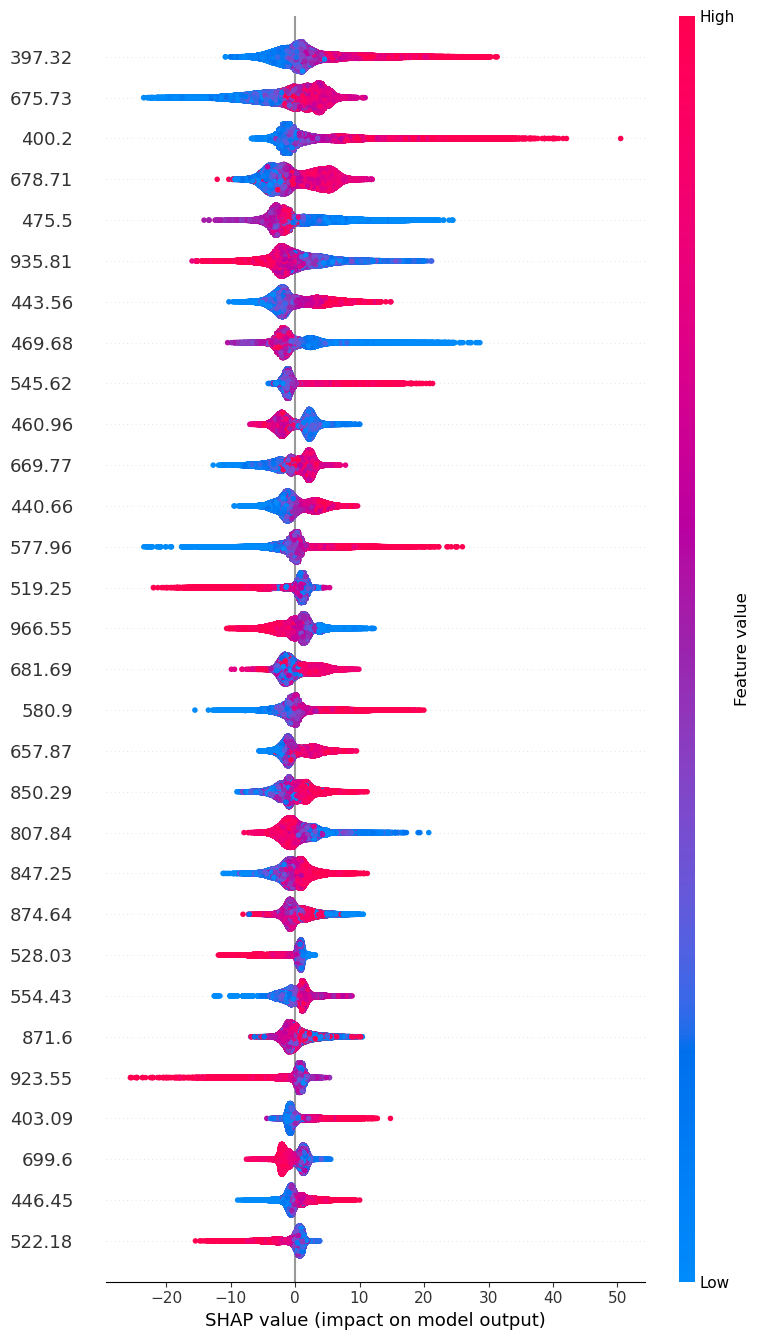

In [11]:
# XGBoost Old Dataset 4 bands deleted
# The summary plot gives a global overview of the feature importance 
# and the effects of the features on the model's predictions.
shap.summary_plot(shap_values, X_test, feature_names=BANDS_WAVELENGTHS, max_display=30)

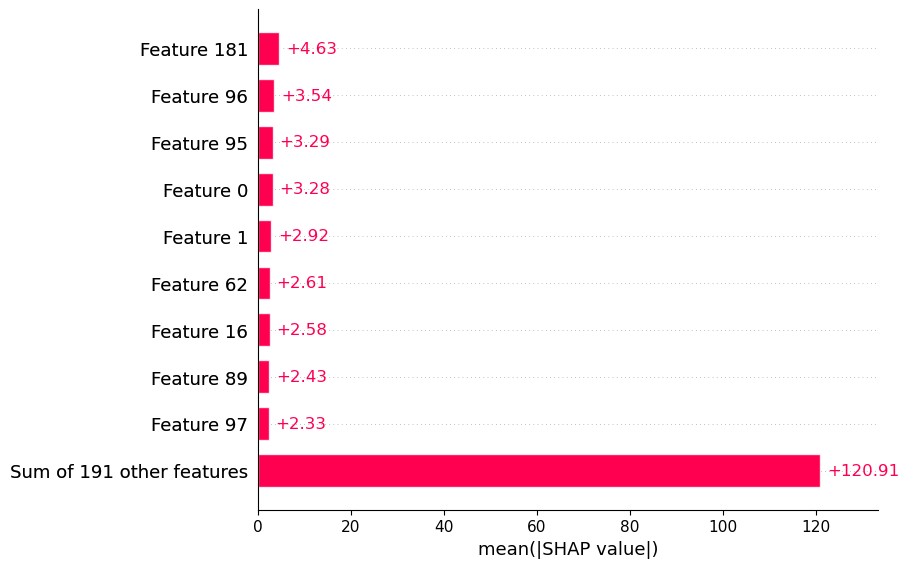

In [14]:
shap.plots.bar(explainer_shap.abs.mean(0))

In [47]:
print(BANDS_WAVELENGTHS[181])
print(BANDS_WAVELENGTHS[62])
print(BANDS_WAVELENGTHS[199])
print(BANDS_WAVELENGTHS[140])
print(BANDS_WAVELENGTHS[95])

935.81
577.96
1003.58
810.86
675.73


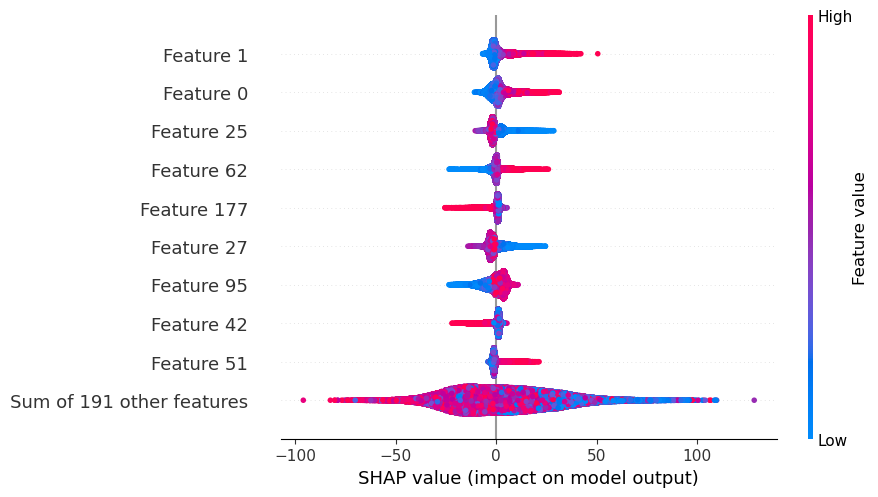

In [12]:
shap.plots.beeswarm(explainer_shap, order=explainer_shap.abs.max(0))

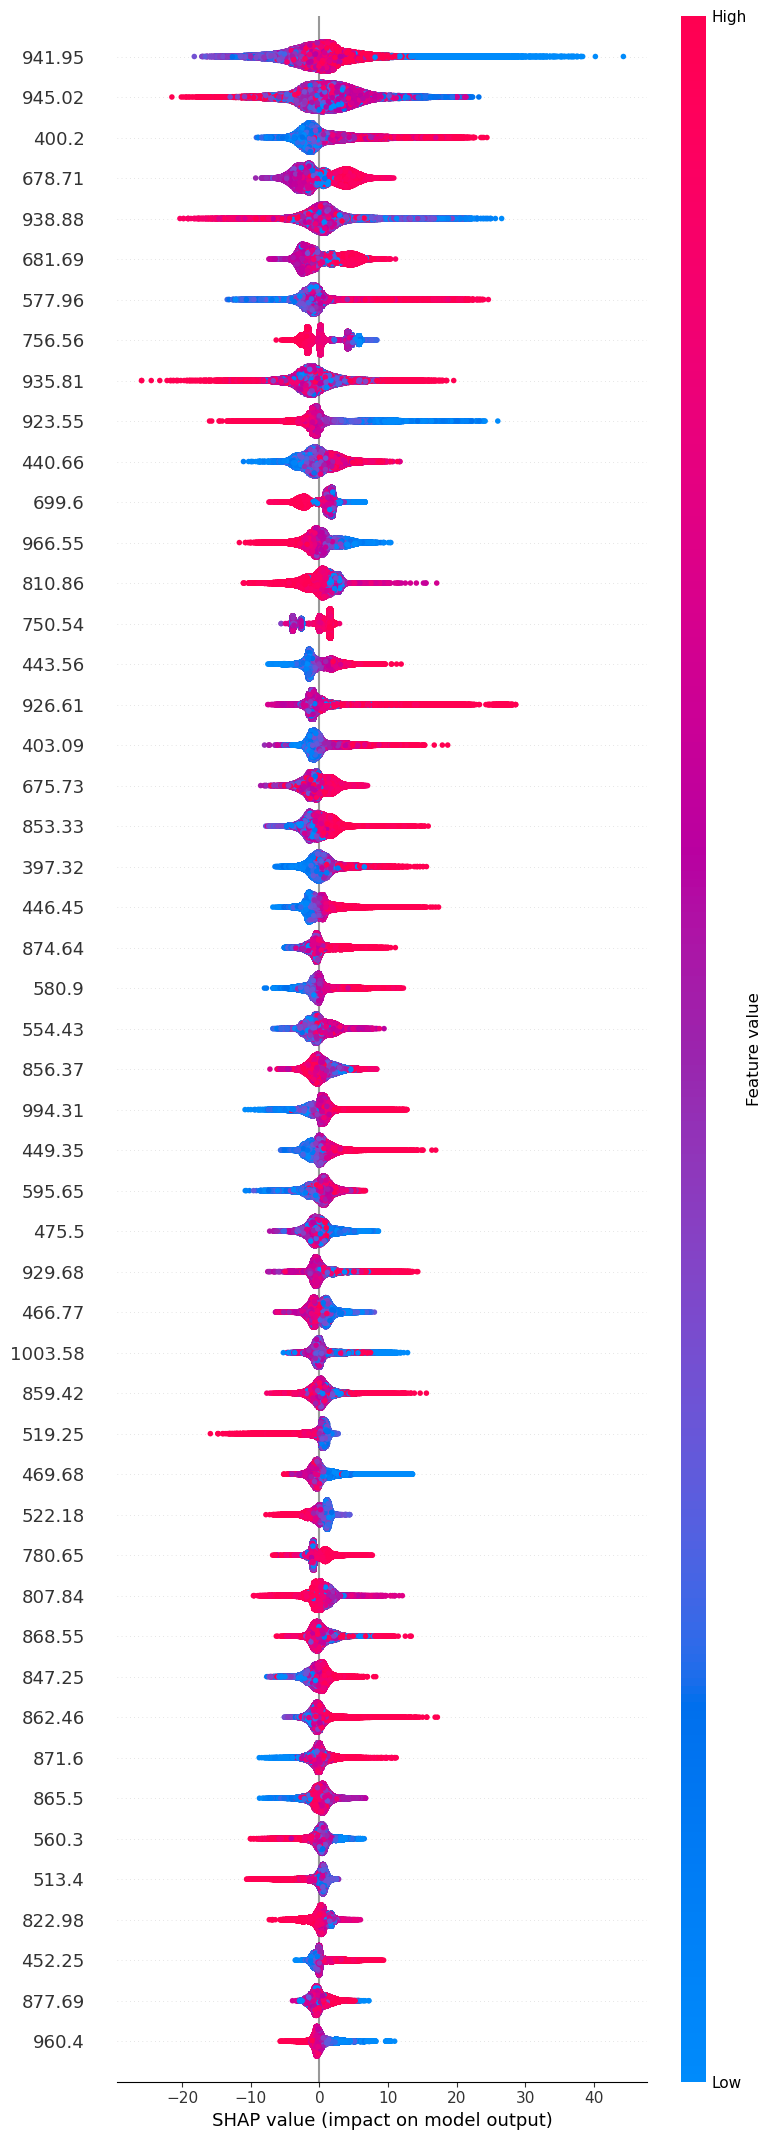

In [11]:
# XGBoost old dataset
# The summary plot gives a global overview of the feature importance 
# and the effects of the features on the model's predictions.
shap.summary_plot(shap_values, X_test, feature_names=BANDS_WAVELENGTHS, max_display=50)

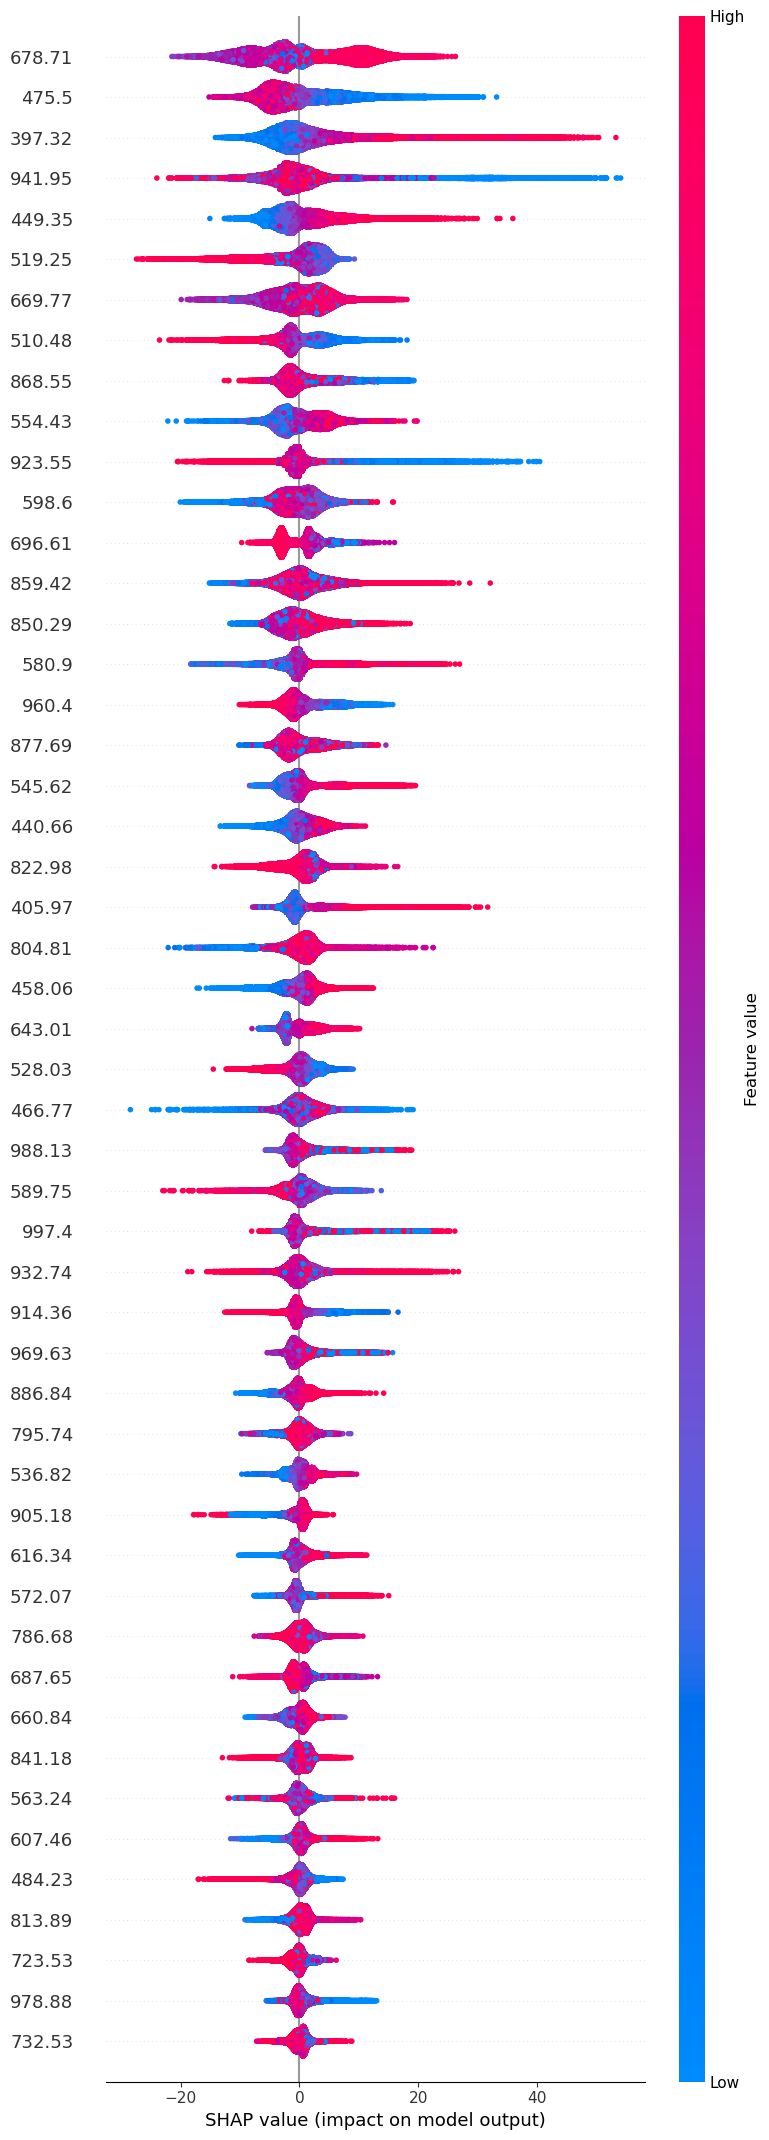

In [13]:
# XGBoost old dataset 68 bands
# The summary plot gives a global overview of the feature importance 
# and the effects of the features on the model's predictions.
shap.summary_plot(shap_values, X_test, feature_names=BANDS_WAVELENGTHS[::3], max_display=50)

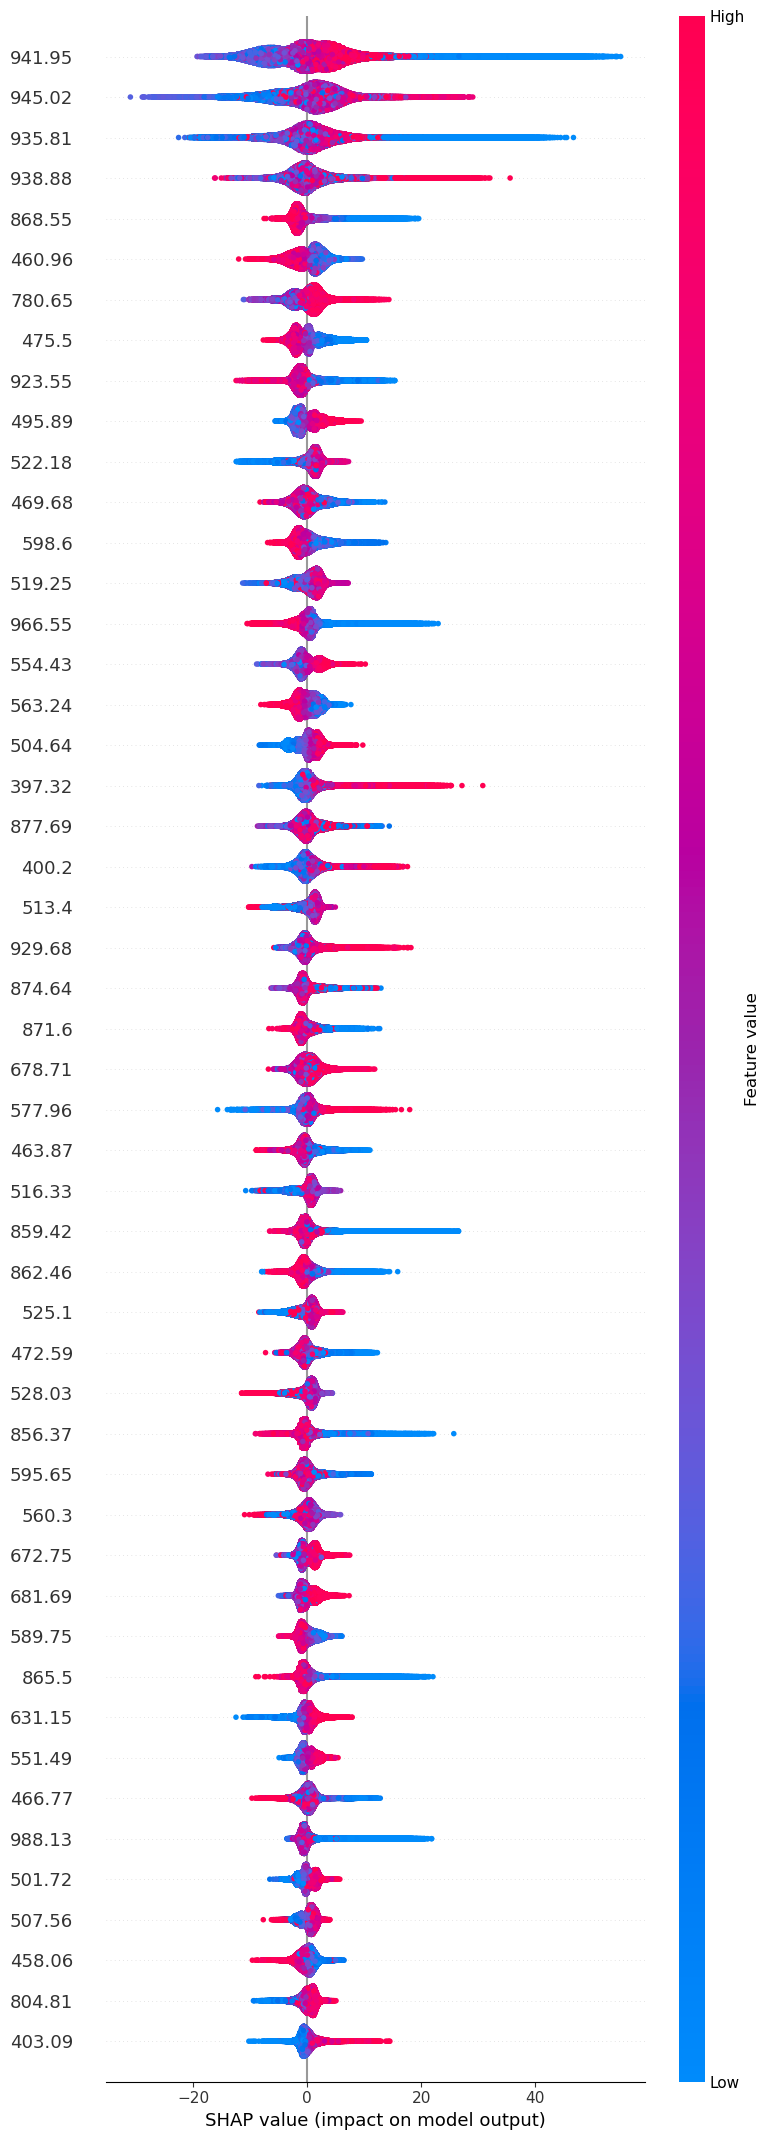

In [7]:
# XGBoost latest dataset Aug 23
# The summary plot gives a global overview of the feature importance 
# and the effects of the features on the model's predictions.
shap.summary_plot(shap_values, X_test, feature_names=BANDS_WAVELENGTHS, max_display=50)

AttributeError: 'float' object has no attribute 'split'

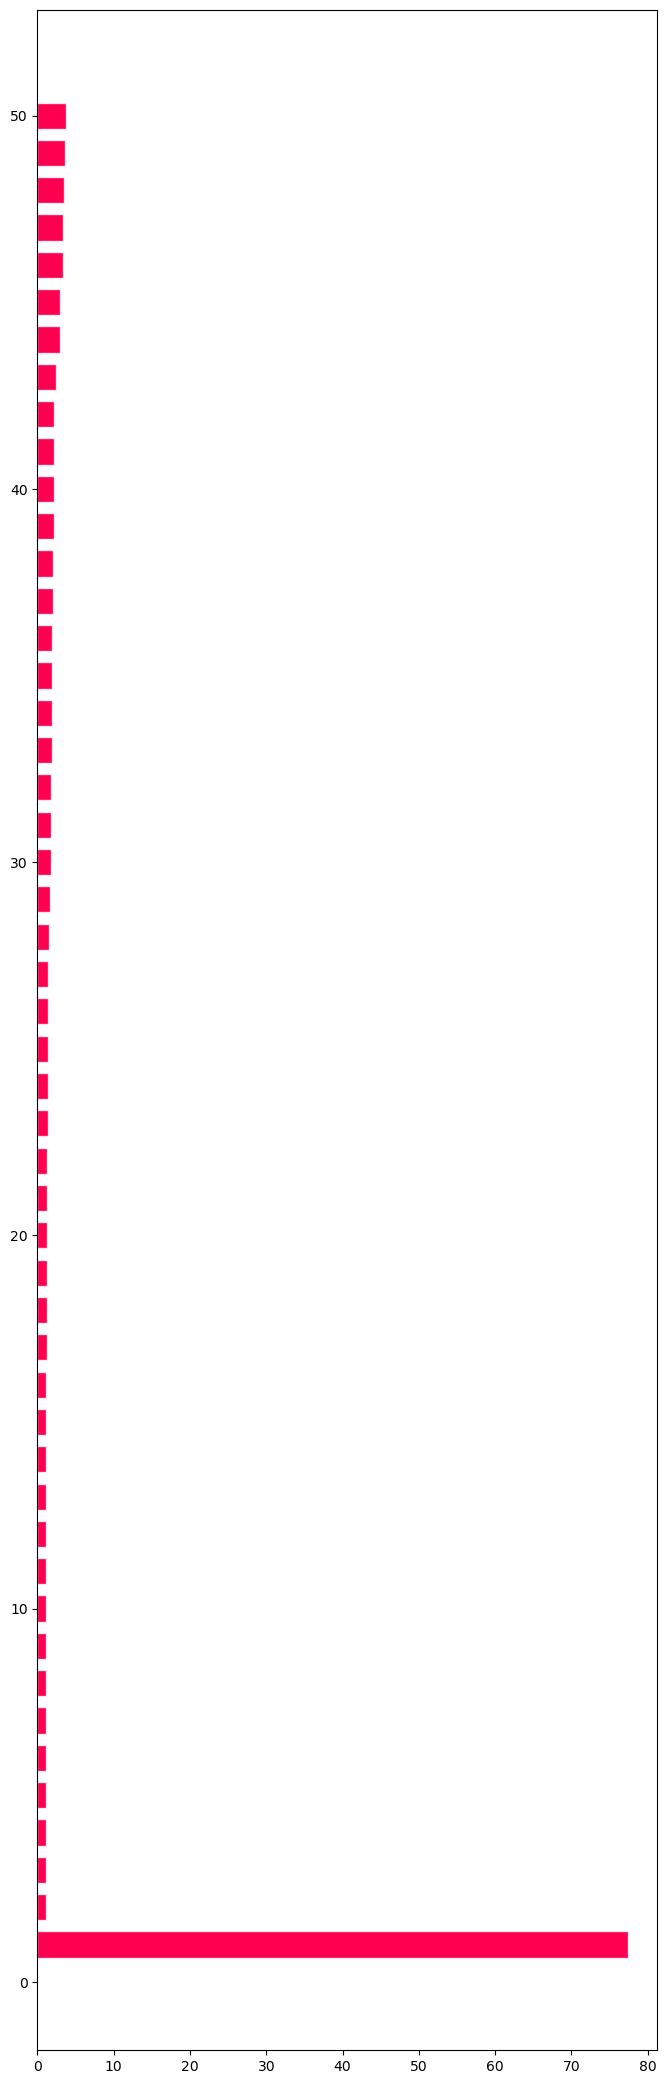

In [14]:
shap.plots.bar(explainer_shap_feature, max_display=50)

In [4]:
shap_values = np.load('shap_values_xgboost.npy')
# Calculate mean absolute SHAP values for each feature
mean_abs_shap_values = np.mean(np.abs(shap_values), axis=0)

# Get the top 30 features
top_20_indices = np.argsort(mean_abs_shap_values)[::-1][:204]

print('Top 20 index: ', top_20_indices)
# # Convert the indices to band wavelengths
# top_30_bands = BANDS_WAVELENGTHS[top_30_indices]
# print('Top 30 bands: ', top_30_bands)

Top 20 index:  [183 184 181 182 159  22 130  27 177  34  43  25  69  42 191  54  57  37
   0 162   1  40 179 161 160  96  62  23  41 156 157  44  26  45 155  68
  56  94  97  66 158  80  53  24 198  36  38  21 138   2 167  88  29  67
  70 151  55  90 174  17 202 188 133  31 200 140 185  63  32 145 100  84
 197 193 168  20 144 154  33  89 152  60  16 178 142  15  30  35 201  46
  64 203  19  71  28  58  52  72 173 194  91 139 150 141 123 164 153 187
 136 128 199 148 149 129 163 180  98  95  39 127 146 189 186 125 147 165
  65  61  48  74 171 116   3  73 109 135  18  75 137 190 122  93 176 175
  50 192 143  77 195 134  47  78 114 170 104  51  81 115  99  92  79 107
  83 118 172 111 105 132 196  76 103  87 166 131 113 110 101 119 102 169
  86 121 112   4 126 124  14 106   5  59 120   6 117  85  49 108  11  82
  13  12   8  10   7   9]


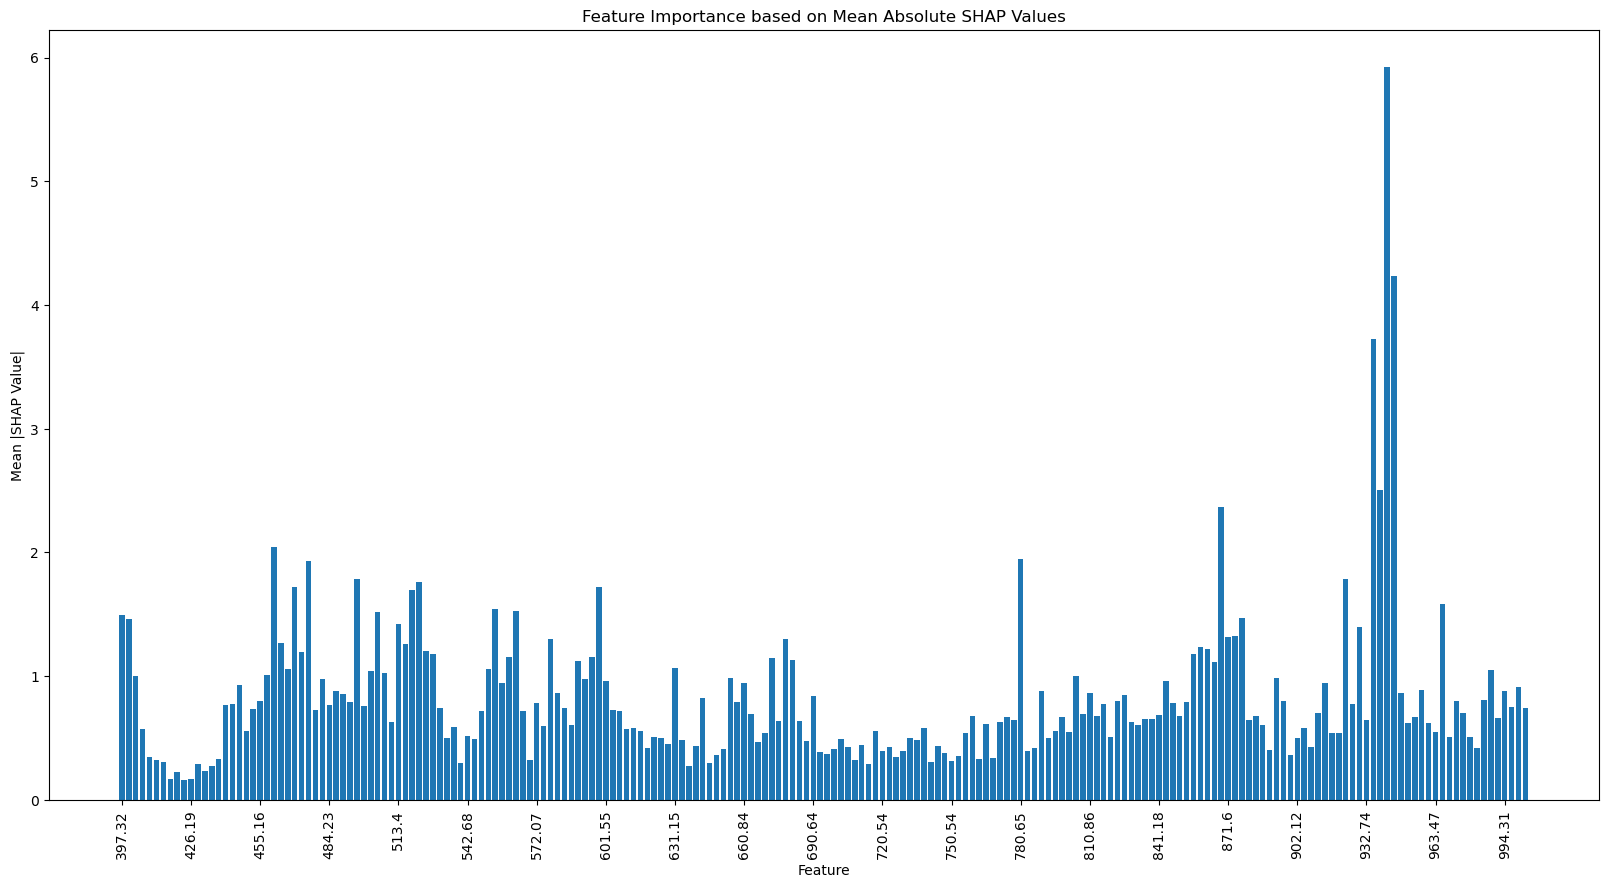

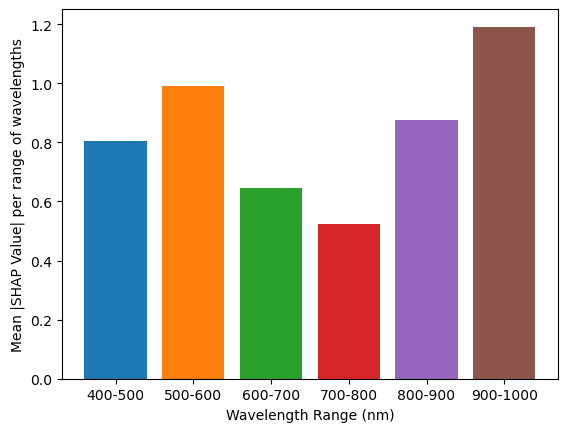

In [6]:
# Calculate mean absolute SHAP values for each feature
mean_abs_shap_values = np.mean(np.abs(shap_values), axis=0)

# Plot using matplotlib
plt.figure(figsize=(20, 10))
plt.bar(range(len(BANDS_WAVELENGTHS)), mean_abs_shap_values)
plt.ylabel('Mean |SHAP Value|')
plt.xlabel('Feature')
plt.title('Feature Importance based on Mean Absolute SHAP Values')
plt.xticks(range(0, 204, 10), BANDS_WAVELENGTHS[0::10], rotation=90)

# # Save the plot to a file
# plt.savefig('XGB_shap_summary_plot.png', bbox_inches='tight')
plt.show()
plt.close()



shap_values = np.load('shap_values_xgboost.npy')
# Calculate mean absolute SHAP values for each feature
mean_abs_shap_values = np.mean(np.abs(shap_values), axis=0)

plt.figure()
# Based on the wavelength in BANDS_WAVELENGTHS, group the bands into [400, 500], [500, 600], [600, 700], [700, 800], [800, 900], [900, 1000+] by averaging the SHAP values
# Plot it with x-axis as the wavelength range and y-axis as the average SHAP value

# Set the x-label and y-label
plt.xlabel('Wavelength Range (nm)')
plt.ylabel('Mean |SHAP Value| per range of wavelengths')

# Calculate mean absolute SHAP values for each group by having the SHAP value of each band
for wavelength_range in [[400, 500], [500, 600], [600, 700], [700, 800], [800, 900], [900, 1000]]:
    start, end = wavelength_range
    indices = [i for i, band in enumerate(BANDS_WAVELENGTHS) if start <= band < end]
    mean_abs_shap_values_group = np.mean(mean_abs_shap_values[indices])
    plt.bar(f'{start}-{end}', mean_abs_shap_values_group)



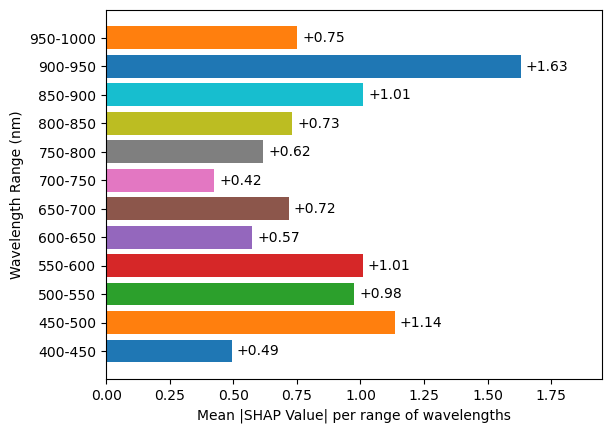

In [32]:
shap_values = np.load('shap_values_xgboost.npy')
# Calculate mean absolute SHAP values for each feature
mean_abs_shap_values = np.mean(np.abs(shap_values), axis=0)

plt.figure()
# Based on the wavelength in BANDS_WAVELENGTHS, group the bands into [400, 450), [450, 500), [500, 550), [550, 600), [600, 650), [650, 700), [700, 750), [750, 800), [800, 850), [850, 900), [900, 950), [950, 1000] by averaging the SHAP values
# Plot it with x-axis as the wavelength range and y-axis as the average SHAP value

# Set the x-label and y-label
plt.ylabel('Wavelength Range (nm)')
plt.xlabel('Mean |SHAP Value| per range of wavelengths')

# Calculate mean absolute SHAP values for each group by having the SHAP value of each band
for wavelength_range in [[400, 450], [450, 500], [500, 550], [550, 600], [600, 650], [650, 700], [700, 750], [750, 800], [800, 850], [850, 900], [900, 950], [950, 1000]]:
    start, end = wavelength_range
    indices = [i for i, band in enumerate(BANDS_WAVELENGTHS) if start <= band < end]
    mean_abs_shap_values_group = np.mean(mean_abs_shap_values[indices])
    # The value is shown on the tip of each bar, like +1.2
    plt.barh(f'{start}-{end}', mean_abs_shap_values_group)
    plt.text(mean_abs_shap_values_group + 0.02, f'{start}-{end}', f'+{mean_abs_shap_values_group:.2f}', ha='left', va='center')

# Set x-axis limits (increase the range)
plt.xlim(0, np.max(mean_abs_shap_values_group) + 1.2)  # Adjust the range as needed


# Show the plot
plt.show()

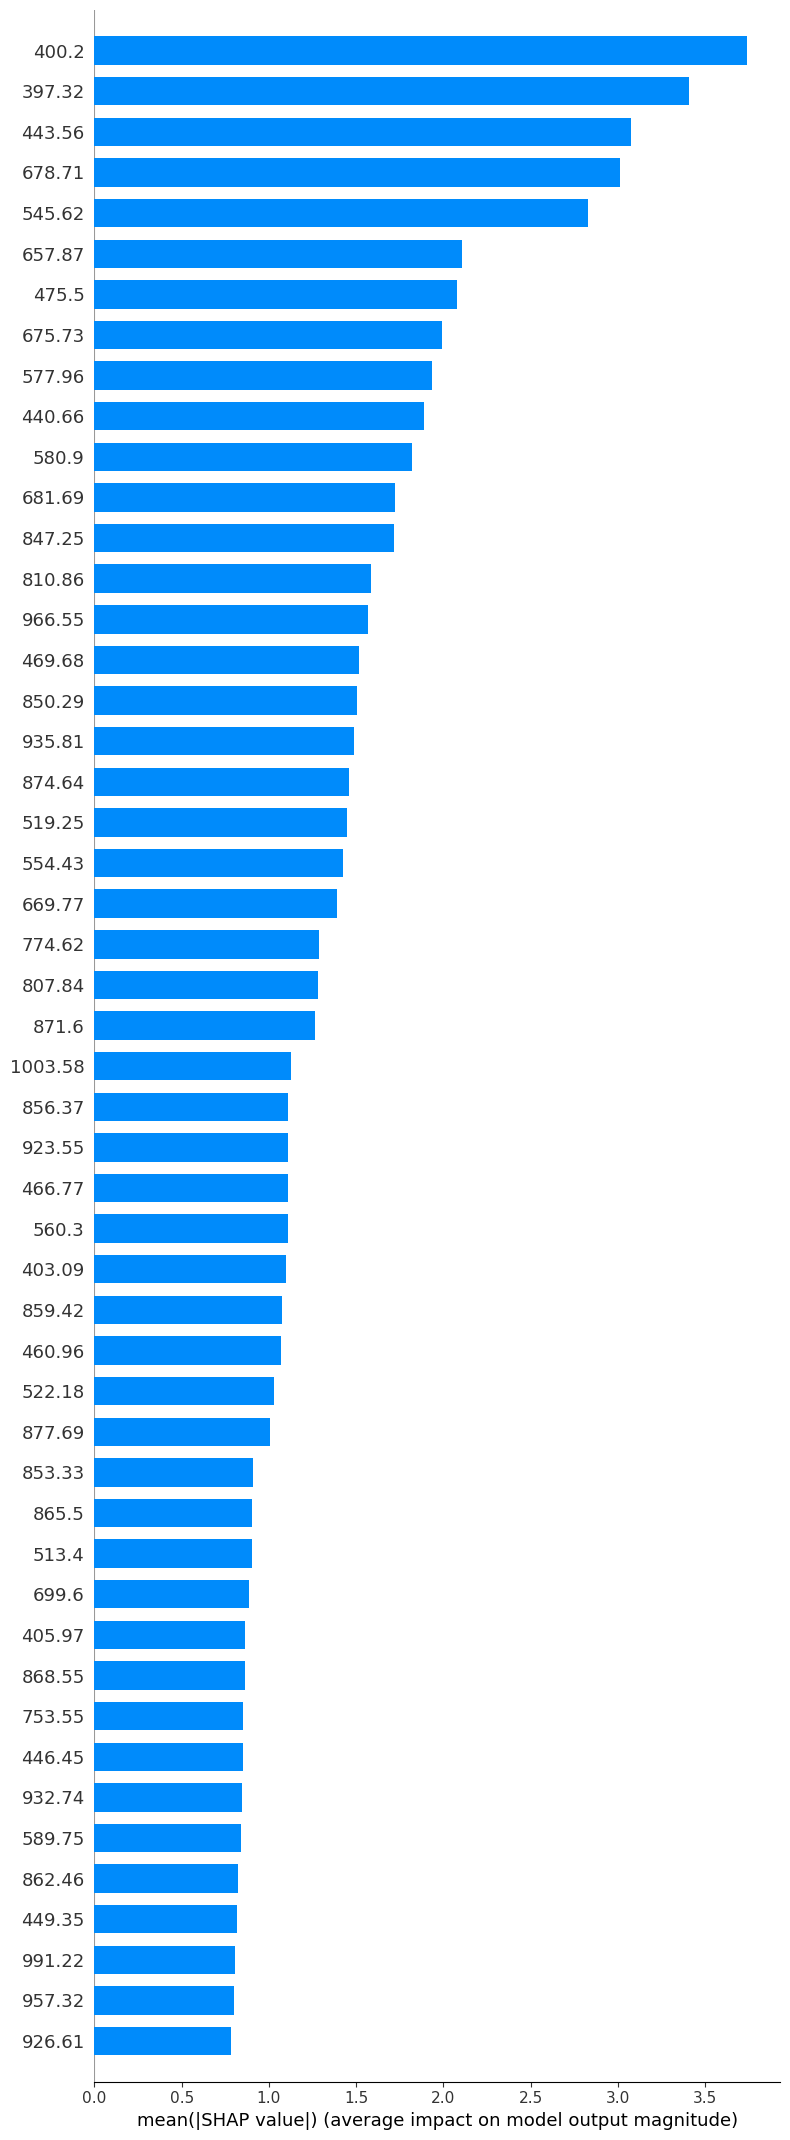

In [13]:
# XGBoost
# The summary plot gives a global overview of the feature importance 
# and the effects of the features on the model's predictions.
shap.summary_plot(shap_values, X_test, feature_names=BANDS_WAVELENGTHS, max_display=50, plot_type='bar')

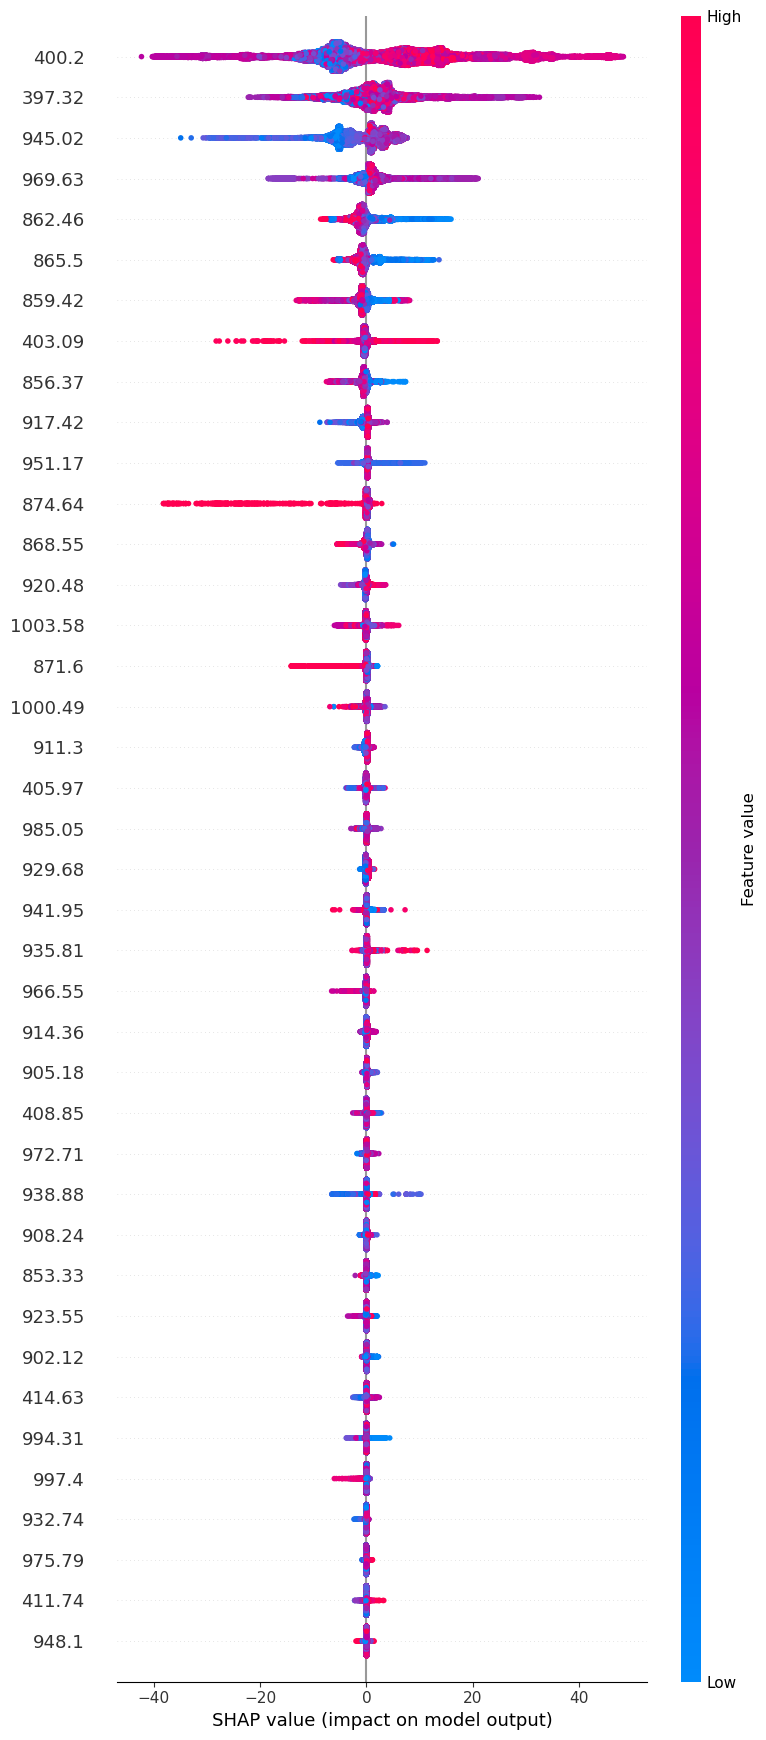

In [ ]:
# Random Forest
# The summary plot gives a global overview of the feature importance 
# and the effects of the features on the model's predictions.
shap.summary_plot(shap_values, X_test, feature_names=BANDS_WAVELENGTHS, max_display=50)

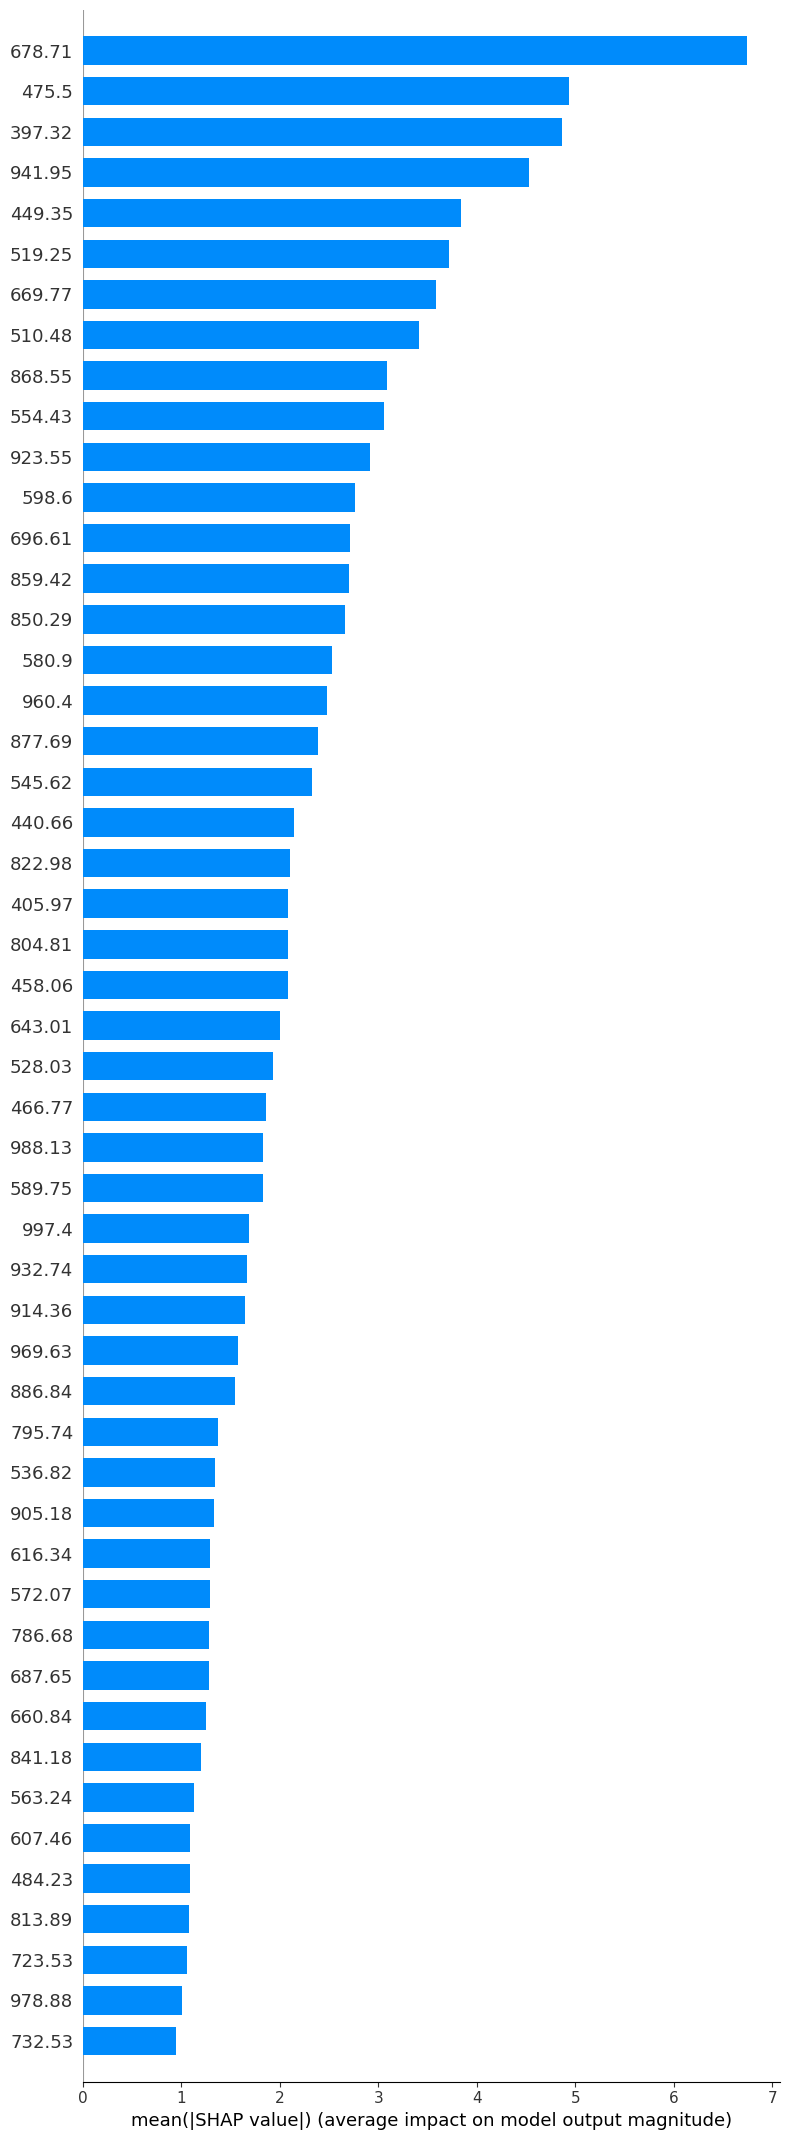

In [16]:
# Random Forest
# The summary plot gives a global overview of the feature importance 
# and the effects of the features on the model's predictions.
shap.summary_plot(shap_values, X_test, feature_names=BANDS_WAVELENGTHS[::3], max_display=50, plot_type='bar')

In [ ]:
# SVR
# The summary plot gives a global overview of the feature importance 
# and the effects of the features on the model's predictions.
shap.summary_plot(shap_values, X_test, feature_names=BANDS_WAVELENGTHS, max_display=40, plot_type='bar')

In [ ]:
# MLP
# The summary plot gives a global overview of the feature importance 
# and the effects of the features on the model's predictions.
shap.summary_plot(shap_values, X_test, feature_names=BANDS_WAVELENGTHS, max_display=200)

In [ ]:
# MLP
# The summary plot gives a global overview of the feature importance 
# and the effects of the features on the model's predictions.
shap.summary_plot(shap_values, X_test, feature_names=BANDS_WAVELENGTHS, max_display=200, plot_type='bar')

In [ ]:
# KNN
# The summary plot gives a global overview of the feature importance
# and the effects of the features on the model's predictions.
shap.summary_plot(shap_values, X_test, feature_names=BANDS_WAVELENGTHS, max_display=50)

In [ ]:
# KNN
# The summary plot gives a global overview of the feature importance 
# and the effects of the features on the model's predictions.
shap.summary_plot(shap_values, X_test, feature_names=BANDS_WAVELENGTHS, max_display=40, plot_type='bar')

In [7]:
explainer_shap = load_model('./Models/ExplainerObject_Shap_xgboost.pkl')
string_BANDSWAVELENGTHS = [str(band) for band in BANDS_WAVELENGTHS]
explainer_shap.feature_names = string_BANDSWAVELENGTHS

In [8]:
plt.figure()
shap.plots.beeswarm(explainer_shap, max_display=20, show=False)
plt.savefig('XGB_shap_beeswarm_plot.png', bbox_inches='tight')
plt.close()

plt.figure()
shap.plots.bar(explainer_shap, max_display=20, show=False)
plt.savefig('XGB_shap_bar_plot.png', bbox_inches='tight')
plt.close()

In [ ]:
indexes = [BANDS_WAVELENGTHS.index(w) for w in [957.32, 628.18, 963.47, 966.55, 645.98, 960.4, 498.8, 443.56, 643.01, 501.72, 554.43, 440.66, 938.88, 678.71, 948.1, 577.96, 405.97, 507.56, 560.3, 504.64, 681.69, 859.42, 575.01, 886.84, 935.81, 446.45, 672.75, 856.37, 865.5, 660.84, 813.89, 929.68, 610.42, 981.96, 841.18, 449.35, 510.48, 868.55, 926.61, 492.97, 607.46, 622.26, 853.33, 969.63, 914.36, 847.25, 1003.58, 684.67, 804.81, 545.62]]
selected_features_indices = indexes

In [9]:
shap_values = np.load('shap_values_xgboost.npy')

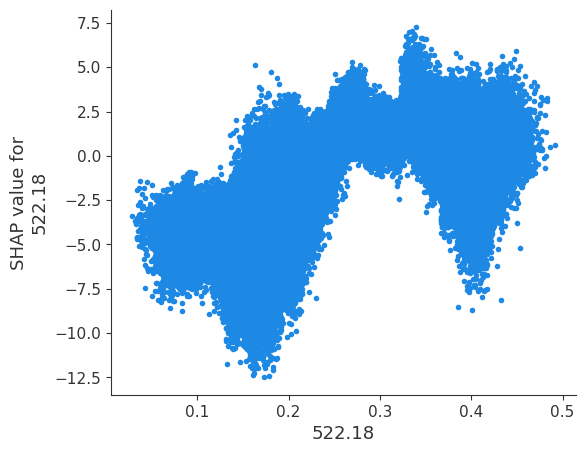

In [23]:
# The dependence plot shows the relationship between the SHAP value of a single feature 
# and the feature value itself, highlighting interactions with other features.
shap.initjs()
shap.dependence_plot("rank(10)", shap_values, X_test, feature_names=BANDS_WAVELENGTHS, interaction_index=None)
# interaction_index“auto”, None, int, or string
# The index of the feature used to color the plot. The name of a feature can also be passed as a string. If “auto” then shap.common.approximate_interactions
# is used to pick what seems to be the strongest interaction (note that to find to true stongest interaction you need to compute the SHAP interaction values).


In [35]:
print(X_train.shape)

(675220, 200)


In [21]:
# The force plot provides a detailed explanation for a single prediction, 
# showing how each feature contributes to pushing the prediction from the base value to the final prediction.
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0, :], X_test[0, :], feature_names=BANDS_WAVELENGTHS)

In [ ]:
# Random Forest
# The summary plot gives a global overview of the feature importance 
# and the effects of the features on the model's predictions.
shap.summary_plot(shap_values, X_test, feature_names=BANDS_WAVELENGTHS, max_display=40)

In [8]:
accuracy_list = []
for i in num_irrelevant_features_eliminated:
    rfe = RFE(model, n_features_to_select=(total_features - i))
    rfe.fit(X_train, y_train)
    y_pred = rfe.predict(X_test)
    accuracy = MSE(y_test, y_pred)
    accuracy_list.append(accuracy)

plt.figure(figsize=(8, 6))
plt.plot(num_irrelevant_features_eliminated, accuracy_list, marker='o')
plt.xlabel("Number of Irrelevant Features Eliminated")
plt.ylabel("Accuracy")
plt.title("Model Performance as Irrelevant Features are Eliminated (RFE)")
plt.grid(True)
plt.show()

## PCA

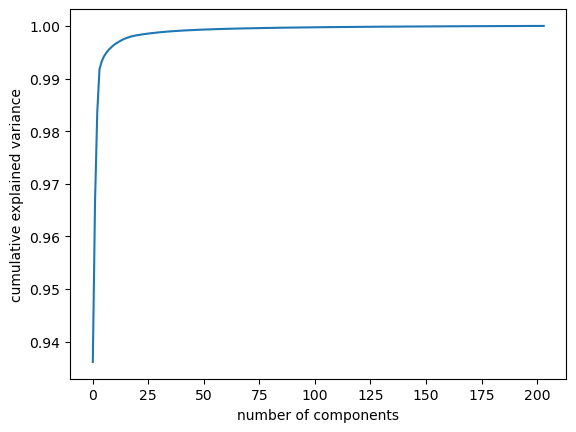

In [5]:
PCA_model = PCA()
PCA_model.fit(X_train)
# visualize the selelcted components
plt.plot(np.cumsum(PCA_model.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

## Random Forest

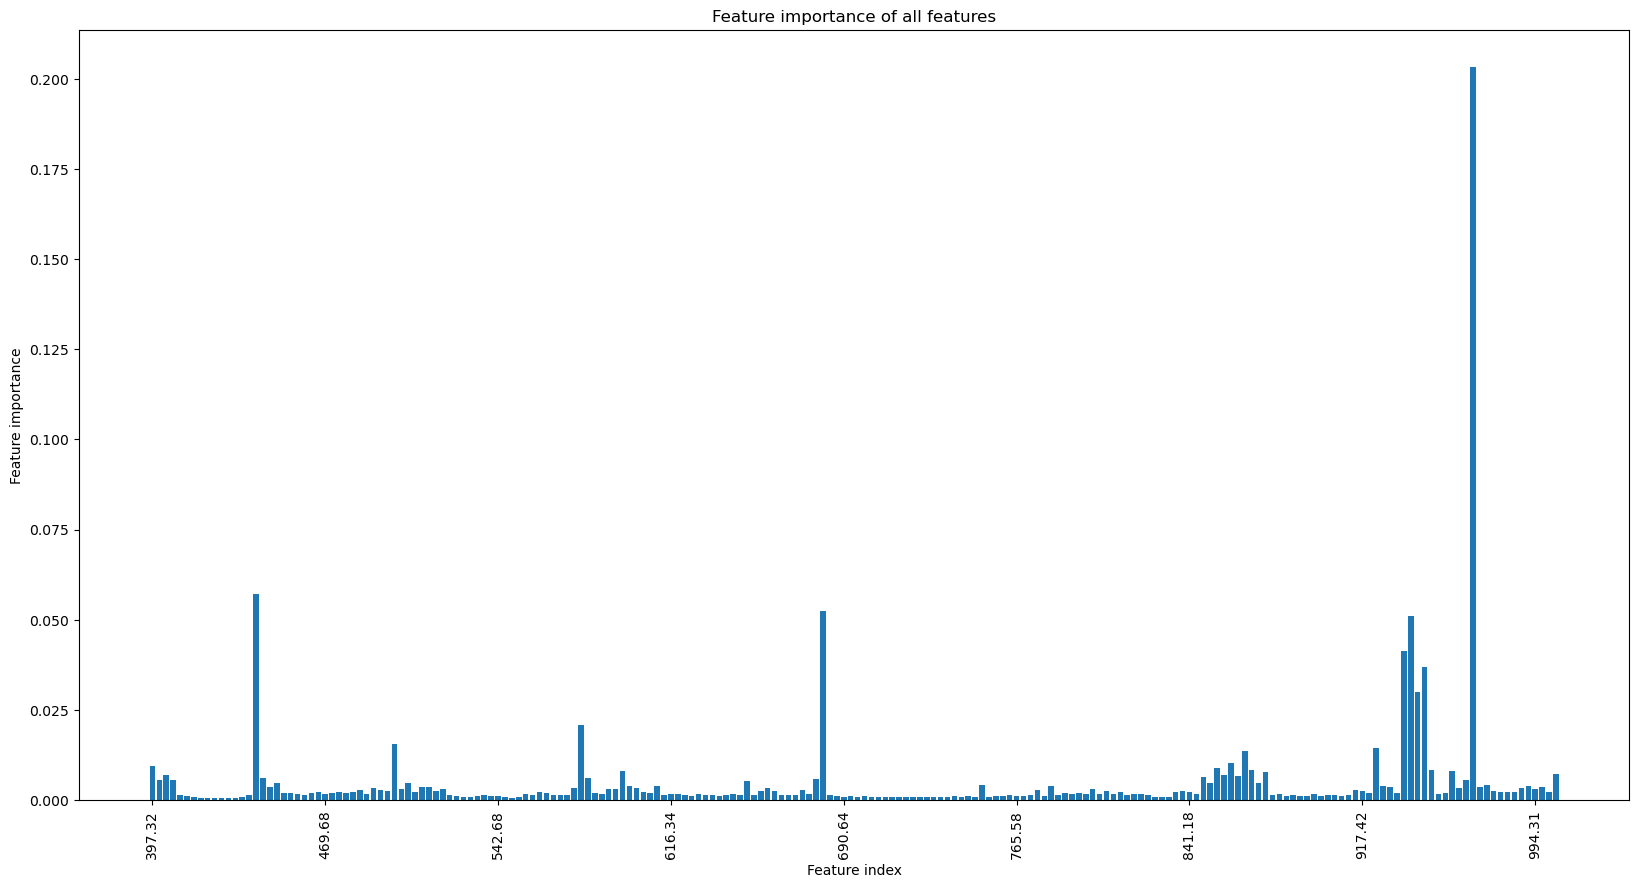

Top 50 features: [191  15  97 182 181 184 183  62  35 177 158 156   0 154 159 185 188  68
 161 203 155   2 157 152  16  63  96 190   1   3  86 160  37  18 153 193
 120 130 199 178  73  69  39  17 179 201  40 192  61  70]


In [7]:
rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_model.fit(X, y)

# Visualize feature importance
plt.figure(figsize=(20, 10))
plt.bar(range(len(BANDS_WAVELENGTHS)), rf_model.feature_importances_)
plt.xlabel("Feature index")
plt.ylabel("Feature importance")
plt.xticks(range(0, 204, 25), BANDS_WAVELENGTHS[0::25], rotation=90)
plt.title("Feature importance of all features")
plt.show()

# Select top features
top_idx = np.argsort(rf_model.feature_importances_)[::-1][:num_features_to_select]
print(f"Top {num_features_to_select} features: {top_idx}")

In [8]:
# top_idx is the index in the BANDS_WAVELENGTHS array
# I want to the corresponding content stored in BANDS_WAVELENGTHS array
wavelengths = [BANDS_WAVELENGTHS[i] for i in top_idx]
print(wavelengths)

[966.55, 440.66, 681.69, 938.88, 935.81, 945.02, 941.95, 577.96, 498.8, 923.55, 865.5, 859.42, 397.32, 853.33, 868.55, 948.1, 957.32, 595.65, 874.64, 1003.58, 856.37, 403.09, 862.46, 847.25, 443.56, 580.9, 678.71, 963.47, 400.2, 405.97, 648.95, 871.6, 504.64, 449.35, 850.29, 972.71, 750.54, 780.65, 991.22, 926.61, 610.42, 598.6, 510.48, 446.45, 929.68, 997.4, 513.4, 969.63, 575.01, 601.55]


In [ ]:
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X, y)

# Visualize feature importance
plt.figure(figsize=(20, 10))
plt.bar(range(len(BANDS_WAVELENGTHS)), rf_model.feature_importances_)
plt.xlabel("Feature index")
plt.ylabel("Feature importance")
plt.xticks(range(0, 204, 25), BANDS_WAVELENGTHS[0::25], rotation=90)
plt.title("Feature importance of all features")
plt.show()

# Select top features
top_idx = np.argsort(rf_model.feature_importances_)[::-1][:num_features_to_select]
print(f"Top {num_features_to_select} features: {top_idx}")

## XGBoost

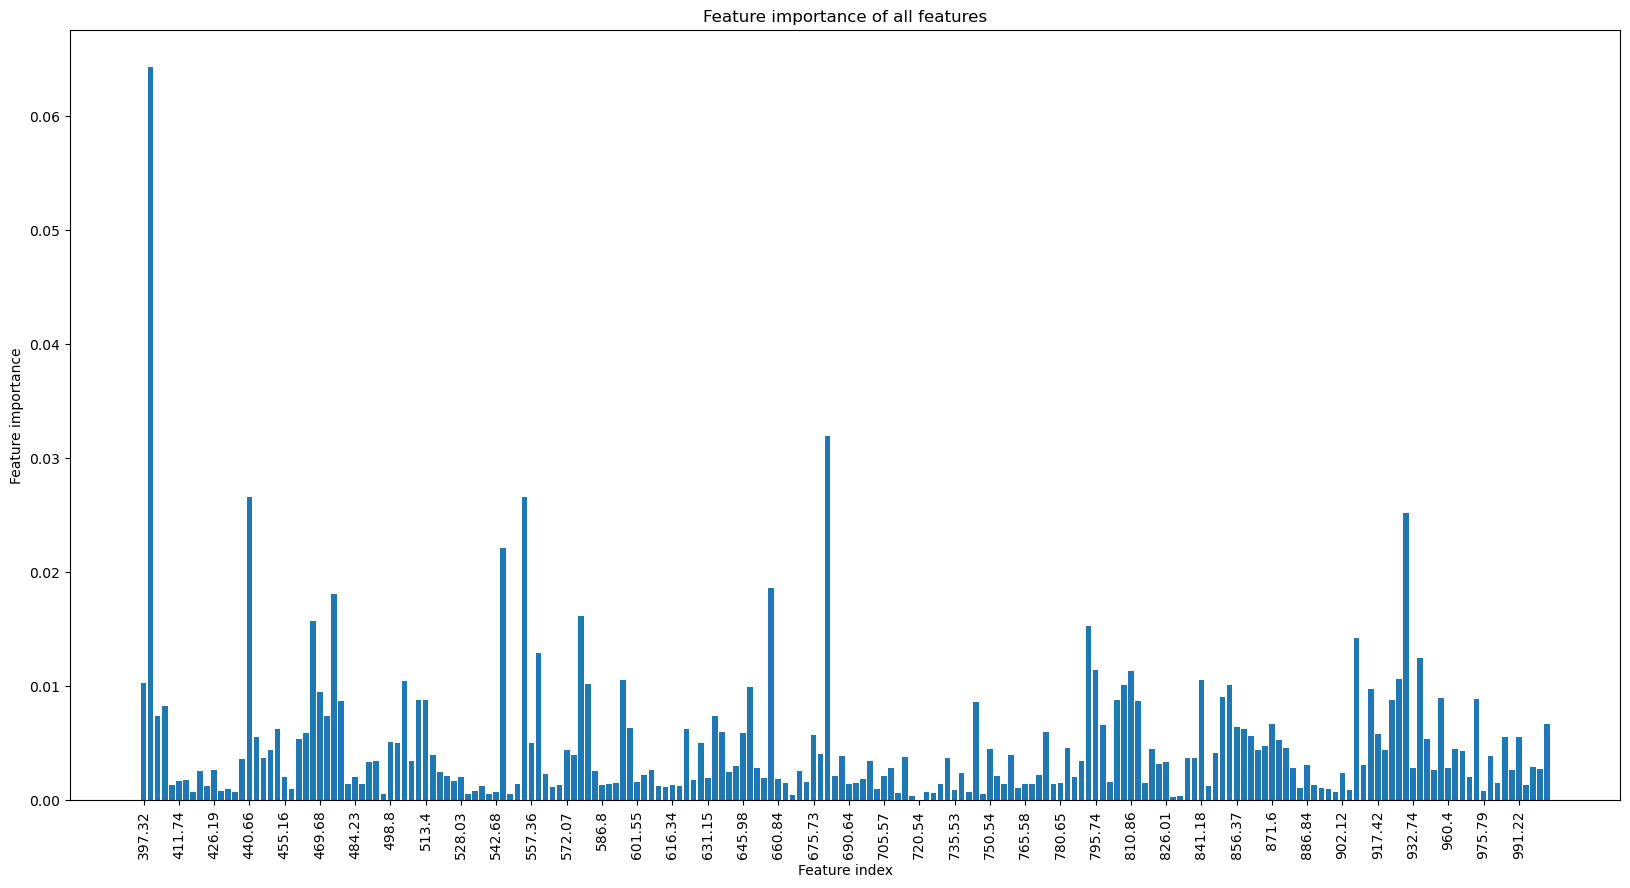

In [14]:
# Robust Scaler, without x_val
xgb_model = XGBRegressor(device='cuda', tree_method='hist', random_state=42, n_jobs=-1, objective='reg:squarederror')
xgb_model.fit(X, y)

# Visualize feature importance
plt.figure(figsize=(20, 10))
plt.bar(range(0,len(BANDS_WAVELENGTHS),1), xgb_model.feature_importances_)
plt.xlabel("Feature index")
plt.ylabel("Feature importance")
plt.xticks(range(0, 200, 5), BANDS_WAVELENGTHS[0::5], rotation=90)
plt.title("Feature importance of all features")
plt.show()

# Select top features
# top_idx = np.argsort(xgb_model.feature_importances_)[::-1][:num_features_to_select]
# print(f"Top {num_features_to_select} features: {top_idx}")

In [10]:
# top_idx is the index in the BANDS_WAVELENGTHS array
# I want to the corresponding content stored in BANDS_WAVELENGTHS array
wavelengths = [BANDS_WAVELENGTHS[i] for i in top_idx]
print(wavelengths)

[966.55, 960.4, 440.66, 681.69, 957.32, 498.8, 657.87, 792.72, 628.18, 948.1, 634.11, 750.54, 938.88, 935.81, 865.5, 504.64, 595.65, 577.96, 963.47, 648.95, 941.95, 923.55, 403.09, 678.71, 569.12, 859.42, 610.42, 672.75, 841.18, 631.15, 945.02, 443.56, 868.55, 563.24, 804.81, 874.64, 475.5, 536.82, 637.08, 446.45, 847.25, 813.89, 994.31, 786.68, 643.01, 853.33, 449.35, 856.37, 871.6, 645.98]


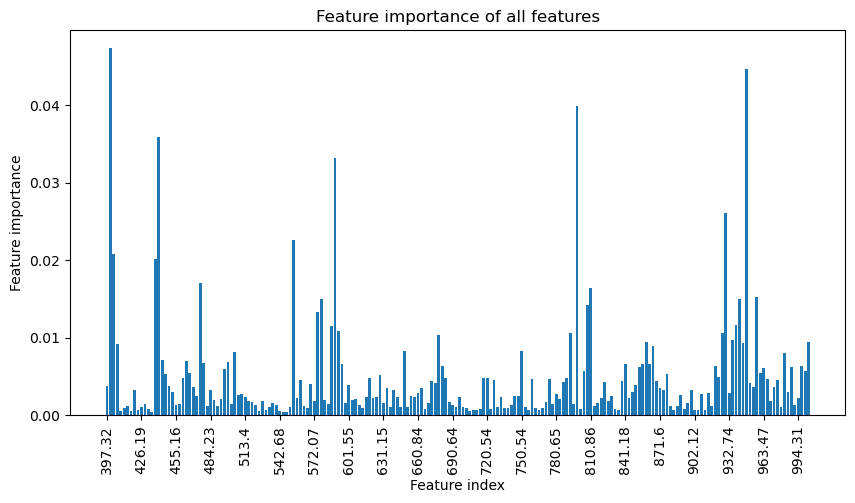

NameError: name 'num_features_to_select' is not defined

In [12]:
# Standard scaler, without x_val
xgb_model = XGBRegressor(random_state=42, n_jobs=-1, objective='reg:squarederror')
xgb_model.fit(X_train, y_train)

# # Visualize feature importance
# plt.figure(figsize=(10, 5))
# plt.bar(range(len(xgb_model.feature_importances_)), xgb_model.feature_importances_)
# plt.xlabel("Feature index")
# plt.ylabel("Feature importance")
# plt.title("Feature importance of all features")
# plt.show()

# # Select top 50 features
# top_50_idx = np.argsort(xgb_model.feature_importances_)[::-1][:50]
# print("Top 50 features: ", top_50_idx)

# Visualize feature importance
plt.figure(figsize=(10, 5))
plt.bar(range(0,len(BANDS_WAVELENGTHS),1), xgb_model.feature_importances_)
plt.xlabel("Feature index")
plt.ylabel("Feature importance")
plt.xticks(range(0, 204, 10), BANDS_WAVELENGTHS[0::10], rotation=90)
plt.title("Feature importance of all features")
plt.show()

# Select top features
# top_idx = np.argsort(xgb_model.feature_importances_)[::-1][:num_features_to_select]
# print(f"Top {num_features_to_select} features: {top_idx}")

## Lasso Regression

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
..............................................[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    1.2s remaining:    1.9s
..............[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.3s finished


LassoCV model fit complete...


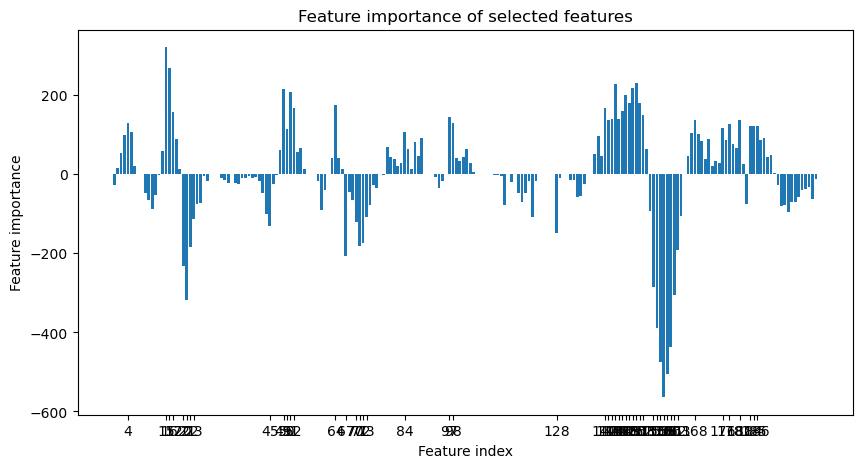

Selected features:  [  4  15  16  17  20  21  22  23  45  49  50  51  52  64  67  70  71  72
  73  84  97  98 128 142 143 144 145 146 147 148 149 150 151 152 153 156
 157 158 159 160 161 162 163 168 176 178 181 184 185 186]


In [ ]:
# Fit LassoCV model 
lasso_cv = LassoCV(cv=10, random_state=42, verbose=True, alphas=[0.0001, 0.001, 0.01, 0.1, 1, 5], n_jobs=-1)
lasso_cv.fit(X, y)

print("LassoCV model fit complete...")
# Feature selection 
sfm = SelectFromModel(lasso_cv, prefit=True, threshold=-np.inf, max_features=num_features_to_select) 
# X_train = sfm.transform(X) 
# X_val = sfm.transform(X_val)
# X_test = sfm.transform(X_test)

# Show dimensions of data after LassoCV
# print("X_train_selected shape: ", X_train.shape)
# print("X_val_selected shape: ", X_val.shape)
# print("X_test_selected shape: ", X_test.shape)

feature_indices = np.array(range(len(lasso_cv.coef_)))

# Analyze selected features and their importance 
selected_feature_indices = np.where(sfm.get_support())[0] 
selected_features = feature_indices[selected_feature_indices] 
coefficients = lasso_cv.coef_ 

# Visualize selected features and their importance
plt.figure(figsize=(10, 5))
plt.bar(feature_indices, coefficients)
plt.xticks(selected_features)
plt.xlabel("Feature index")
plt.ylabel("Feature importance")
plt.title("Feature importance of selected features")
plt.show()

# Show selected features
print("Selected features: ", selected_feature_indices)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
........................[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:  5.6min remaining:  8.4min
....................................[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  5.8min finished


LassoCV model fit complete...
X_train_selected shape:  (4088984, 50)
X_val_selected shape:  (1752422, 50)
X_test_selected shape:  (1540764, 50)


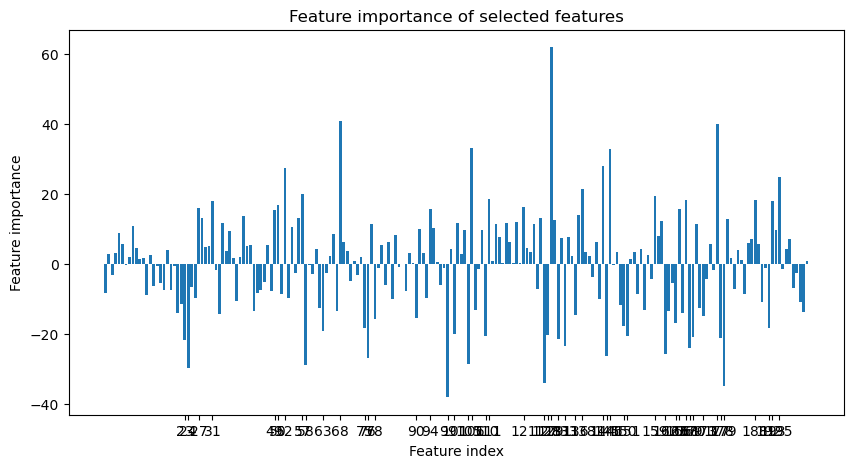

Selected features:  [ 23  24  27  31  49  50  52  57  58  63  68  75  76  78  90  94  99 101
 105 106 110 111 121 127 128 129 131 133 136 138 144 145 146 150 151 159
 162 165 166 168 169 170 173 177 178 179 188 192 193 195]


In [17]:
# Fit LassoCV model 
lasso_cv = LassoCV(cv=10, random_state=42, verbose=True, alphas=[0.0001, 0.001, 0.01, 0.1, 1, 5], n_jobs=-1)
lasso_cv.fit(X_train, y_train)

print("LassoCV model fit complete...")
# Feature selection 
sfm = SelectFromModel(lasso_cv, prefit=True, threshold=-np.inf, max_features=num_features_to_select) 
X_train = sfm.transform(X_train) 
X_val = sfm.transform(X_val)
X_test = sfm.transform(X_test)

# Show dimensions of data after LassoCV
print("X_train_selected shape: ", X_train.shape)
print("X_val_selected shape: ", X_val.shape)
print("X_test_selected shape: ", X_test.shape)

feature_indices = np.array(range(len(lasso_cv.coef_)))

# Analyze selected features and their importance 
selected_feature_indices = np.where(sfm.get_support())[0] 
selected_features = feature_indices[selected_feature_indices] 
coefficients = lasso_cv.coef_ 

# Visualize selected features and their importance
plt.figure(figsize=(10, 5))
plt.bar(feature_indices, coefficients)
plt.xticks(selected_features)
plt.xlabel("Feature index")
plt.ylabel("Feature importance")
plt.title("Feature importance of selected features")
plt.show()

# Show selected features
print("Selected features: ", selected_feature_indices)

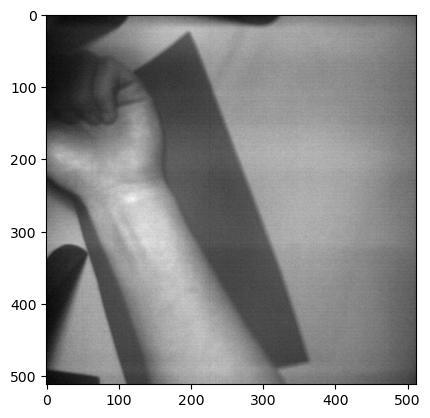

In [15]:
# Show image
file = '../datasets/dataset_glucose/Hyperspectral/HS_GT/2749.mat'

bands = 0
show_image(file, bands)